<a href="https://colab.research.google.com/github/mostakimjihad/EnFER-ViT/blob/main/EnFER_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python
!pip install bayesian-optimization

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052 (from 1)
Receiving objects: 100% (34052/34052), 52.31 MiB | 20.16 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_t1j4ecw
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_t1j4ecw
  Resolved https://github.com/albumentations-team/albumentations to commit eab8836fe96a0b2a0f997f4edc9f2e3fce212b19
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.7/680.7 kB 26.0 MB/s eta 0:00:00
  Created wheel for albumentations: filename

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2  # Import OpenCV
from torch.optim.lr_scheduler import StepLR
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 2

DEVICE = 'cuda'
MODEL_NAME = 'EnsembleModel'

# Load Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from PIL import Image

In [ ]:
def apply_orb(image):
    # Convert the image to grayscale as ORB requires a single channel input
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)

    # Draw keypoints on the image
    keypoint_image = cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0), flags=0)

    return keypoint_image

class ORBImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image_array = np.array(image)  # Convert PIL image to numpy array
        image_with_keypoints = apply_orb(image_array)  # Apply ORB
        image_with_keypoints = Image.fromarray(image_with_keypoints)  # Convert back to PIL image
        if self.transform:
            image_with_keypoints = self.transform(image_with_keypoints)
        return image_with_keypoints, label

    @property
    def class_to_idx(self):
        return self.dataset.class_to_idx

In [ ]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),  # Convert images to tensors before normalization
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_augs = T.Compose([
    T.ToTensor(),  # Convert images to tensors before normalization
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = ORBImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ORBImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
def normalize_image(image):
    """Normalize PIL Image to be in the valid range [0, 1] for displaying."""
    image = np.array(image)  # Convert PIL Image to numpy array if not already
    if image.dtype == np.uint8:
        # Image is in integer format, no need to normalize
        return image
    else:
        # Assume image is in float format, normalize to [0, 1]
        return (image - image.min()) / (image.max() - image.min())

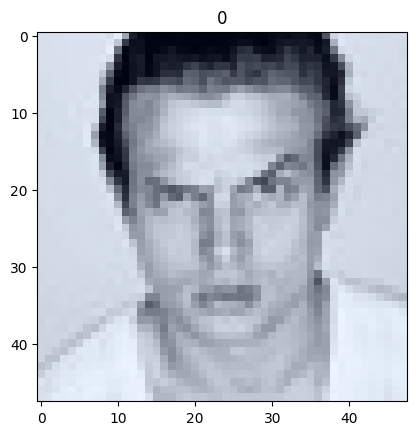

In [ ]:
image, label = validset[36]

image = image.permute(1, 2, 0).numpy()  # Convert to channel-last format and then to NumPy
image = normalize_image(image)  # Normalize the NumPy array

image = normalize_image(image)  # Normalize the image
plt.imshow(image) #(h, w, c)
plt.title(label);
plt.show()

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model (Resnet-50,EfficientNet)

In [ ]:
import timm
from torch import nn

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNetModel, self).__init__()
        # Load pre-trained ResNet
        self.resnet = timm.create_model('resnet50', pretrained=True)

        # Replace the last fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, images):
        # Get the feature vector before the classification layer
        features = self.resnet.forward_features(images)
        return features

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetModel, self).__init__()
        # Load pre-trained EfficientNet
        self.eff_net = timm.create_model('efficientnet_b4', pretrained=True)

        # Replace the last fully connected layer
        num_features = self.eff_net.classifier.in_features
        self.eff_net.classifier = nn.Linear(num_features, num_classes)

    def forward(self, images):
        # Get the feature vector before the classification layer
        features = self.eff_net.forward_features(images)
        return features

# Ensemble Model:

In [ ]:
import torch
from torch import nn
import timm

class EnhancedEnsembleModel(nn.Module):
    def __init__(self, resnet_model, effnet_model, num_classes=7, dropout_rate=0.5):
        super(EnhancedEnsembleModel, self).__init__()
        self.resnet_model = resnet_model
        self.effnet_model = effnet_model

        combined_feature_size = 15360

        self.fusion = nn.Linear(combined_feature_size, 1024)

        # Batch Normalization and Dropout
        self.batch_norm = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(dropout_rate)

        # Final classifier layer
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, images, labels=None):
        # Extract features from both models
        resnet_features = self.resnet_model(images)
        effnet_features = self.effnet_model(images)

        # Ensure features are correctly reshaped before concatenation
        resnet_features = resnet_features.view(resnet_features.size(0), -1)
        effnet_features = effnet_features.view(effnet_features.size(0), -1)

        # Concatenate the features from both models
        combined_features = torch.cat((resnet_features, effnet_features), dim=1)

        # Pass combined features through the fusion layer, batch normalization, and dropout
        combined_features = self.dropout(self.batch_norm(torch.relu(self.fusion(combined_features))))

        # Output logits from the classifier
        logits = self.classifier(combined_features)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return logits, loss
        return logits

In [ ]:
# Create ResNet-50 and EfficientNet models
resnet_model = ResNetModel()
effnet_model = EfficientNetModel()

# Create the ensemble model
enhancedensemblemodel = EnhancedEnsembleModel(resnet_model, effnet_model)

# Move the ensemble model to the specified device
enhancedensemblemodel.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(enhancedensemblemodel, dataloader, optimizer, current_epo):
    enhancedensemblemodel.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCH [TRAIN] " + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        output = enhancedensemblemodel(images, labels)

        # Check if output includes loss
        if isinstance(output, tuple):
            logits, loss = output
        else:
            logits = output
            loss = nn.CrossEntropyLoss()(logits, labels)  # Calculate loss if not provided

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' % float(total_loss / (t + 1)), 'acc' : '%6f' % float(total_acc / (t + 1))})

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
def eval_fn(enhancedensemblemodel, dataloader, current_epo):
    enhancedensemblemodel.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCH [VALID] " + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            output = enhancedensemblemodel(images, labels)

            # Check if output includes loss
            if isinstance(output, tuple):
                logits, loss = output
            else:
                logits = output
                loss = nn.CrossEntropyLoss()(logits, labels)  # Calculate loss if not provided

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)
            tk.set_postfix({'loss' : '%6f' % float(total_loss / (t + 1)), 'acc' : '%6f' % float(total_acc / (t + 1))})

    return total_loss / len(dataloader), total_acc / len(dataloader)


# **Bayesian Optimization**

In [ ]:
def train_evaluate(learning_rate, weight_decay):
    optimizer = torch.optim.Adam(enhancedensemblemodel.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(EPOCHS):
        train_fn(enhancedensemblemodel, trainloader, optimizer, epoch)
        valid_loss, valid_acc = eval_fn(enhancedensemblemodel, validloader, epoch)

    return valid_acc.item()

    # Define the hyperparameter space
params = {
    'learning_rate': (1e-5, 1e-2),
    'weight_decay': (1e-5, 1e-3)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=train_evaluate, pbounds=params, random_state=1)
optimizer.maximize(init_points=2, n_iter=2)

# Extract the best parameters
best_params = optimizer.max['params']
print("Best Parameters:", best_params)

|   iter    |  target   | learni... | weight... |
-------------------------------------------------


EPOCH [VALID] 2/2: 100%|██████████| 221/221 [00:14<00:00, 15.12it/s, loss=1.927996, acc=0.262161]


| 1         | 0.2622    | 0.004176  | 0.0007231 |


EPOCH [VALID] 2/2: 100%|██████████| 221/221 [00:15<00:00, 14.70it/s, loss=42.491351, acc=0.314414]


| 2         | 0.3144    | 1.114e-05 | 0.0003093 |


EPOCH [VALID] 2/2: 100%|██████████| 221/221 [00:14<00:00, 15.16it/s, loss=2.233657, acc=0.382038]


| 3         | 0.382     | 1.903e-05 | 0.000293  |


EPOCH [VALID] 2/2: 100%|██████████| 221/221 [00:14<00:00, 15.19it/s, loss=3.131713, acc=0.434705]

| 4         | 0.4347    | 2.584e-05 | 0.0002829 |
Best Parameters: {'learning_rate': 2.5838841849159447e-05, 'weight_decay': 0.00028293263334140347}


# Create Training Loop

In [ ]:
# Best hyperparameters from Bayesian Optimization
best_lr = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']

resnet_model = ResNetModel()
effnet_model = EfficientNetModel()
enhancedensemblemodel = EnhancedEnsembleModel(resnet_model, effnet_model)
enhancedensemblemodel.to(DEVICE)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Update the optimizer with weight decay
optimizer = torch.optim.Adam(enhancedensemblemodel.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=1)

# Initialize the variable to track the best validation loss
best_valid_loss = float('inf')
best_valid_acc = 0
best_train_loss = float('inf')
best_train_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_fn(enhancedensemblemodel, trainloader, optimizer, epoch)
    valid_loss, valid_acc = eval_fn(enhancedensemblemodel, validloader, epoch)

    # Append values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    # Check for improvements in training metrics
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_acc = train_acc

    # Check for improvement in validation metrics
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc  # Update the best validation accuracy
        torch.save(enhancedensemblemodel.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")

    scheduler.step()  # Update the learning rate

# Print the best metrics achieved
print(f"Best Training Loss: {best_train_loss}")
print(f"Best Training Accuracy: {best_train_acc}")
print(f"Best Validation Loss: {best_valid_loss}")
print(f"Best Validation Accuracy: {best_valid_acc}")

EPOCH [VALID] 1/2: 100%|██████████| 221/221 [00:15<00:00, 14.41it/s, loss=2.332206, acc=0.319896]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 2/2: 100%|██████████| 221/221 [00:14<00:00, 15.14it/s, loss=2.529574, acc=0.335701]

Best Training Loss: 1.8999095161535366
Best Training Accuracy: 0.28366464376449585
Best Validation Loss: 2.3322055706611047
Best Validation Accuracy: 0.3198964297771454


# **Inference Section**

In [ ]:
import torch.nn.functional as F

def view_classify(img, logits):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    # Ensure img is a numpy array
    img = img.cpu().numpy().squeeze()

    # Check if image needs to be transposed
    if img.shape[0] < img.shape[2]:  # Assuming channel-first format
        img = img.transpose(1, 2, 0)  # Convert to channel-last format for displaying

    # Normalize the image to [0, 1] for displaying
    img = (img - img.min()) / (img.max() - img.min())

    fig, (ax1, ax2) = plt.subplots(figsize=(5, 9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')

    # No need to reshape logits as softmax can handle it directly
    probs = F.softmax(logits, dim=1)
    probs = probs.squeeze().cpu().detach().numpy()  # Convert to numpy array

    ax2.barh(classes, probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

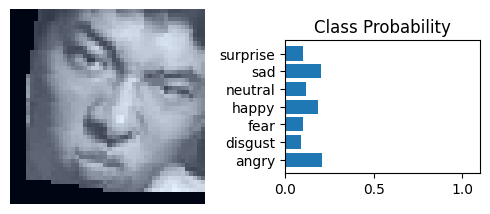

In [ ]:
image, label = trainset[1376]
image = image.unsqueeze(0)  # Add batch dimension
logits = enhancedensemblemodel(image.to(DEVICE))  # Forward pass
view_classify(image.squeeze(0), logits)  # Remove batch dimension for displaying

# Training and validation loss+accuracy graph

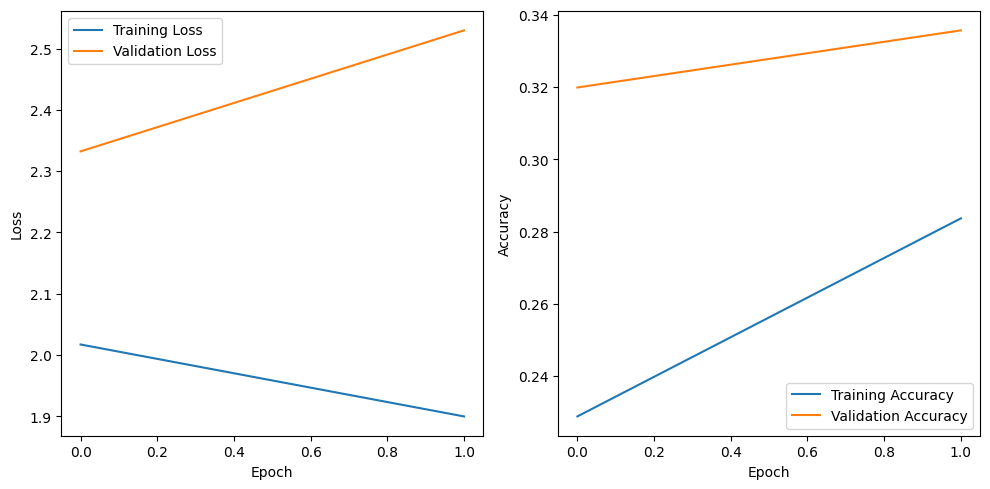

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# classification report

EPOCH[VALID]2:   0%|          | 0/221 [00:00<?, ?it/s]

Logits: 

EPOCH[VALID]2:   0%|          | 1/221 [00:00<01:23,  2.65it/s]

tensor([[-0.3075, -0.9455, -1.1292,  0.7336,  0.4647, -0.6154, -0.3255],
        [ 0.3051,  0.2278,  0.6274, -0.0777,  0.5113,  1.4726, -0.2028],
        [-0.0334, -1.0145, -0.2155, -0.0669, -0.2912,  0.3147, -0.9226],
        [ 0.0030, -0.2809,  0.3807, -0.7866, -1.1393,  0.1372,  0.8432],
        [ 0.5809, -0.3599,  0.6032, -0.2922, -0.8554,  0.3783, -0.5889],
        [ 0.2745, -0.2672,  0.0690,  1.1144, -0.5482,  0.0810, -0.2403],
        [ 0.5335, -0.1551, -0.3306,  0.8415, -0.4483, -0.2703,  0.1597],
        [ 0.4397, -0.6246, -0.0190,  0.2278,  0.0079,  0.3812, -0.5145],
        [ 1.1440,  0.4471, -0.8345,  1.3775, -1.0497, -0.6039, -1.5949],
        [ 0.0127, -0.2006,  0.4320,  1.2981,  0.7005, -0.1783, -0.6630],
        [-0.1457,  0.4792,  1.4503, -0.0544,  0.5211, -0.3499,  0.3280],
        [-0.0091,  0.0844,  0.1382,  0.5569,  1.1870,  0.4891, -0.5882],
        [-0.6381, -0.9184,  0.2110,  0.5246, -0.1137, -0.3178, -0.2521],
        [ 0.1716, -0.1999,  0.0576, -0.3789,  0.601

EPOCH[VALID]2:   2%|▏         | 5/221 [00:00<00:26,  8.26it/s]

tensor([[-4.6130e-01, -1.2104e+00, -4.8905e-01, -7.1442e-01, -9.9509e-01,
         -1.9330e-01, -4.4273e-02],
        [ 1.0714e-01, -2.9924e-01, -5.2833e-01,  1.0381e+00, -1.7403e-01,
          1.5488e-01, -1.0745e+00],
        [ 2.3121e-01, -1.6676e-02, -3.2436e-01,  2.4327e-01,  1.5510e-01,
         -1.7268e-02, -5.0922e-01],
        [ 3.4298e-01,  2.5183e-01,  1.2471e+00, -3.1437e-01,  1.2220e+00,
          2.2597e-01,  2.9025e-01],
        [ 9.6275e-01, -4.3550e-01, -1.2647e-01,  3.2783e-02, -1.1385e-01,
          2.1760e-01,  4.4470e-01],
        [-5.1019e-01, -2.2866e-01,  1.5990e-01,  4.4106e-01,  3.2199e-02,
         -4.0022e-01, -2.2295e-01],
        [ 9.5994e-01,  7.1319e-01,  3.2720e-01, -1.3607e-02, -4.6815e-01,
         -2.5470e-02, -4.9973e-01],
        [ 9.3753e-01,  1.7466e-01,  6.6186e-02,  1.1050e-01,  4.2572e-01,
          1.0754e+00, -1.8073e+00],
        [ 2.6422e-01,  3.4462e-02,  3.9471e-01,  1.5025e+00,  3.0943e-01,
         -1.7734e+00,  1.4605e+00],
        [ 

EPOCH[VALID]2:   3%|▎         | 7/221 [00:00<00:21,  9.82it/s]

Logits: tensor([[-1.0185e+00, -1.1798e+00, -6.8656e-01,  1.4619e+00, -6.9373e-01,
         -5.8205e-01, -1.9051e+00],
        [ 2.0540e-01, -2.4237e-01, -3.9387e-01,  8.9454e-01,  4.2726e-01,
         -2.9614e-01, -4.0901e-01],
        [-7.1305e-01, -1.1704e+00, -5.6323e-01,  1.4157e-01, -6.4095e-01,
         -5.9284e-01, -5.2534e-01],
        [-1.4985e-01, -9.5414e-01, -7.8931e-01,  9.4214e-02, -6.0853e-01,
          2.8433e-01, -5.8918e-01],
        [-5.8723e-04, -9.9092e-02, -2.8646e-01,  8.1815e-01,  5.6878e-01,
         -5.3757e-01,  4.9321e-02],
        [-3.9251e-02,  2.4879e-01,  9.2413e-01, -6.5084e-01,  5.9810e-01,
          6.2307e-01,  1.6283e-01],
        [-7.0975e-01, -6.0012e-01, -2.3746e-02,  2.7023e-01, -5.4219e-01,
          1.8401e-01,  3.6311e-01],
        [ 6.1578e-01,  7.9181e-01,  3.9601e-02, -8.1576e-01,  1.3281e+00,
         -6.9070e-01,  7.0122e-01],
        [-2.9724e-01, -7.1239e-02, -4.3418e-01,  6.9705e-01, -5.2770e-02,
         -4.0535e-01, -5.5552e-01],
  

EPOCH[VALID]2:   4%|▍         | 9/221 [00:01<00:19, 10.78it/s]

Logits: tensor([[ 0.8930,  0.4572,  0.7677, -0.1505,  0.2618,  0.2587, -0.8051],
        [ 0.8092, -0.7336,  1.6973, -2.3001,  0.6460,  1.6914, -1.1560],
        [ 0.9381,  0.0704,  0.4344, -0.3108, -0.2500, -0.5563, -0.0978],
        [ 0.9032,  0.1446,  0.7242, -0.9292,  0.7314,  0.6025, -1.0933],
        [ 0.0169,  0.4189,  0.2467, -0.5005,  1.3414,  1.5596, -0.2564],
        [-0.1951,  0.3864,  0.2085, -0.1535, -0.5616,  0.3678,  0.4277],
        [ 0.6252,  0.2128, -0.1152,  0.9141,  0.6774,  0.5453, -0.6173],
        [-0.2836, -1.3554, -0.8384,  0.4671, -1.1598,  0.0312, -1.7867],
        [ 0.2956,  0.2891, -0.0361,  1.4830,  0.7732,  0.1242,  0.2786],
        [ 0.2756, -0.2113, -0.2002, -1.0495,  1.1731,  0.2972, -0.2574],
        [-0.3286, -0.1324,  0.4043,  0.3925,  0.0212,  0.1873, -0.6631],
        [ 0.3390, -0.0666,  1.1460, -1.2738,  0.0653,  0.0384,  1.7323],
        [-0.6223, -0.3174, -0.3319,  0.9496, -0.5790,  0.5986, -0.1144],
        [-0.7904, -1.7385, -1.9623,  1.4751

EPOCH[VALID]2:   5%|▍         | 11/221 [00:01<00:20, 10.30it/s]

Logits: tensor([[-1.5632e-01, -4.1815e-01, -7.1801e-02, -2.2448e-01,  4.7610e-01,
         -9.6514e-02,  1.5696e-01],
        [-2.8185e-01, -4.4627e-01, -2.9370e-01,  1.3786e+00, -1.8655e-01,
         -8.2715e-01, -1.8011e-01],
        [-2.4508e-01, -2.4150e-01, -1.2282e-01,  1.2211e+00, -2.9646e-01,
         -3.3634e-01, -2.2191e-01],
        [-1.5466e-01, -7.2414e-01, -9.7738e-01,  2.8712e+00, -1.6643e+00,
         -2.0561e+00, -2.9031e+00],
        [ 1.6340e-01,  1.1015e-01,  1.9154e-01,  3.4894e-01,  1.1138e+00,
         -2.1109e-01, -1.9027e-01],
        [ 1.9493e-01, -8.1544e-01, -1.1596e+00,  1.0131e+00, -7.7783e-01,
         -2.3359e-01, -3.3269e-01],
        [ 8.3809e-01,  1.0753e-01,  7.2406e-01, -8.8365e-01,  1.5411e+00,
         -4.7658e-01,  4.2708e-01],
        [ 4.9963e-01, -3.3256e-01,  2.4302e-01,  2.1582e-01,  5.7405e-01,
          9.9900e-01, -1.1459e+00],
        [ 5.5083e-01, -4.0679e-01,  5.6116e-01, -2.0418e+00,  5.2611e-01,
          8.3195e-01, -6.2432e-01],
  

EPOCH[VALID]2:   7%|▋         | 15/221 [00:01<00:19, 10.36it/s]

Logits: tensor([[ 8.8297e-01, -1.1182e-01,  2.9751e-01,  1.1405e+00, -3.7689e-01,
          3.1015e-01, -1.4525e-01],
        [ 2.4791e-01, -1.2034e-01, -5.5007e-01,  2.2706e-01,  8.6952e-02,
          1.1012e+00, -1.0527e+00],
        [ 2.3133e-01, -7.1321e-01, -2.2395e-01,  1.8093e-02,  2.4563e-01,
          1.1920e-01, -9.6311e-01],
        [ 3.4958e-01, -3.5426e-01, -1.1552e-01,  1.3113e+00,  6.4956e-01,
          5.0829e-01, -9.6813e-01],
        [-2.5858e-01, -7.2155e-01,  1.4380e+00, -1.1873e+00, -2.0780e+00,
          6.0590e-01,  6.6296e-01],
        [ 9.5824e-01, -3.4257e-01, -2.8192e-02, -1.1756e+00,  5.9411e-01,
          6.1714e-01, -1.3342e-01],
        [ 2.8127e+00,  3.6882e+00,  2.6675e+00,  3.4353e+00, -9.9842e-01,
         -4.7915e+00,  1.2020e+00],
        [-1.6573e-01, -5.2500e-01,  9.4664e-02, -3.2172e-01,  4.1971e-01,
          6.1063e-01, -3.8313e-02],
        [ 8.2907e-01, -2.6356e-01,  3.3730e-01,  9.8911e-02, -1.3451e-01,
          2.9398e-01, -2.5526e-02],
  

EPOCH[VALID]2:   9%|▊         | 19/221 [00:02<00:19, 10.33it/s]

Logits: tensor([[ 7.2362e-01, -9.4336e-01, -3.6470e-03,  4.7787e-01, -2.9651e-01,
         -7.2936e-01,  4.6295e-01],
        [-3.9246e-01, -4.8267e-01, -6.7346e-01,  1.3410e+00, -1.6223e-01,
          5.7950e-01, -5.0729e-01],
        [ 6.8581e-01, -1.2215e-01,  4.5558e-01,  1.3779e-01, -5.4988e-02,
          6.7674e-01,  1.1889e-01],
        [ 7.9695e-02, -9.9074e-02, -2.6167e-01,  1.2716e+00,  4.2151e-01,
         -1.2702e-01, -5.5429e-01],
        [ 8.9630e-01, -1.0018e+00,  9.6252e-03, -2.6425e-01, -5.2857e-01,
          5.9585e-01,  1.4924e-01],
        [ 5.1811e-01, -3.2196e-01, -2.0775e-01,  2.4681e+00, -9.3735e-01,
         -1.9902e-01, -1.2201e+00],
        [ 5.5303e-01, -2.4885e-01, -9.9916e-02,  7.9008e-01,  1.5184e+00,
         -4.1049e-01, -1.0902e-01],
        [ 6.0375e-01, -8.1703e-03, -3.6144e-01,  3.5587e-01,  7.5324e-03,
          4.0702e-01, -5.6602e-01],
        [ 5.7758e-01,  4.6857e-01,  1.1259e+00, -9.5499e-01, -5.1790e-01,
         -2.8890e-01,  1.4940e+00],
  

EPOCH[VALID]2:  10%|▉         | 21/221 [00:02<00:19, 10.45it/s]

Logits: tensor([[ 7.8926e-01, -4.8801e-02, -6.3799e-01,  6.1245e-02,  4.7427e-01,
          1.8052e+00, -1.6729e+00],
        [ 7.5159e-01, -1.5863e-01,  5.3929e-01, -1.3732e-01,  1.4953e-01,
          4.8418e-01, -4.4354e-01],
        [-2.4829e-01, -9.3322e-01, -1.4107e-01,  9.1975e-01, -1.0004e+00,
         -1.0452e+00, -2.4885e-01],
        [ 7.2537e-01,  6.5494e-01,  3.2629e-01,  4.3117e-01,  4.5326e-01,
          1.4393e+00, -1.6344e+00],
        [ 4.2569e-01,  2.6946e-01,  7.8528e-01, -1.7178e-01, -8.1520e-01,
          1.5824e+00, -8.8275e-01],
        [ 5.2676e-01,  1.3938e-01, -2.9323e-01,  5.2520e-01,  6.4157e-01,
          5.3063e-01, -7.1946e-01],
        [-2.8515e-01, -8.6836e-01, -1.0208e-01,  5.7409e-01, -1.1959e-01,
          2.0302e-01, -9.4383e-01],
        [ 1.4042e-01,  9.6966e-03,  1.8416e-01, -5.0866e-01,  9.3960e-01,
          4.6289e-01, -4.6578e-01],
        [-3.1487e-03,  2.1762e-01,  4.6424e-01, -3.0093e-02,  6.5520e-01,
         -1.7723e-01, -4.4495e-01],
  

EPOCH[VALID]2:  10%|█         | 23/221 [00:02<00:19,  9.93it/s]

Logits: tensor([[ 7.9549e-01, -6.3984e+00, -3.8426e+00,  2.6216e+00,  1.7490e+00,
         -1.0234e+01, -7.4795e-01],
        [ 1.3774e+00,  3.2998e-02,  2.8407e-01,  6.5220e-01,  1.1000e+00,
          9.0354e-01,  4.5542e-01],
        [ 1.2822e-01, -7.2812e-01,  5.6155e-01,  1.0523e+00, -1.2978e-01,
         -3.5551e-01, -4.4654e-01],
        [ 4.4676e-01,  5.9289e-02, -2.0071e-01,  2.5638e-01,  1.1623e+00,
          4.4559e-02, -1.1296e-01],
        [ 6.6261e-01,  7.2045e-01, -7.6833e-02,  1.3380e+00,  1.8079e-01,
          8.3505e-01, -1.4933e-01],
        [-2.6151e-01, -3.3534e-01, -4.0794e-01,  2.9201e-01,  3.9170e-01,
         -3.2982e-01,  4.7293e-02],
        [-2.0391e+00, -5.6846e+00, -5.5328e+00, -4.7244e+00, -1.9001e+00,
         -1.3678e+01, -1.4468e+00],
        [-1.9471e-02, -5.2726e-01, -6.0797e-01,  8.3073e-01, -4.6062e-02,
         -2.8150e-02, -3.1208e-01],
        [ 8.8017e-01,  9.5562e-02,  4.9196e-01,  6.7898e-01,  3.5308e-02,
          9.2441e-01, -4.3934e-01],
  

EPOCH[VALID]2:  11%|█▏        | 25/221 [00:02<00:19,  9.83it/s]

Logits: tensor([[ 0.6483, -0.2545,  0.4226, -0.5903, -0.1580,  1.4931, -0.4527],
        [ 0.1264,  0.5462,  0.9396,  0.6727,  0.4668,  0.4630,  1.3428],
        [ 0.5554,  0.3697,  0.1107,  0.7882, -0.0158,  0.4818, -0.7764],
        [-0.1927, -0.5619,  0.0891,  0.6741,  0.8649,  0.5238, -0.6232],
        [ 0.8150, -0.2997, -0.1012,  0.9706, -0.8661,  1.0395, -1.4216],
        [ 0.0509, -0.4499,  0.6136, -0.3236,  0.5217, -0.0174, -1.5388],
        [ 0.3328,  0.2263,  0.3372,  0.0703,  0.8376,  0.5533,  0.4847],
        [ 0.3506,  0.4490, -0.0087,  1.2268,  0.1167,  0.8109, -0.8695],
        [ 0.2842,  0.3663,  0.1783, -1.5765,  0.8949,  0.6709,  0.4248],
        [ 0.3051, -0.7628,  0.7537, -0.3762, -0.0968, -0.0740,  0.3171],
        [-0.8699, -1.5179, -0.6770,  1.6311, -0.9594, -0.1287, -0.7293],
        [ 0.3473, -1.2510, -0.3139, -1.1766, -0.2486, -0.5662, -0.0213],
        [-0.1576, -0.3843,  0.8460, -0.0848,  0.1267,  0.4640, -0.2085],
        [-0.2103,  0.0739,  0.5457,  1.2691

EPOCH[VALID]2:  12%|█▏        | 27/221 [00:02<00:20,  9.44it/s]

Logits: tensor([[ 4.7667e-02, -7.6856e-01, -5.8483e-01,  5.1127e-01, -9.9098e-01,
         -2.0350e-01, -8.0411e-01],
        [-1.1719e-01, -7.7967e-01, -9.2357e-01,  1.3940e+00, -1.1887e+00,
         -8.5584e-01, -8.0451e-01],
        [-3.9343e-01, -2.6329e-01, -1.7990e-01,  1.2674e+00,  6.7167e-02,
         -8.5697e-01,  2.2169e-01],
        [-3.2764e-01,  1.1604e-01,  5.2457e-01,  4.3539e-01, -5.1793e-01,
         -1.3581e+00,  2.7749e+00],
        [-3.1995e-01, -3.2771e-01, -4.0374e-01,  3.2840e-01,  3.3401e-01,
          5.9350e-01, -7.7589e-01],
        [ 3.8395e-01, -4.4148e-01, -5.3278e-01,  1.0400e+00, -8.5589e-01,
          2.1428e-01, -4.4314e-01],
        [ 5.7909e+00,  9.8053e+00,  1.7722e+00,  5.1406e+00, -1.1632e+01,
         -1.7206e+01, -1.1418e+00],
        [-1.7886e-01, -4.8088e-01, -2.8341e-01, -1.8783e-01,  3.0424e-01,
         -4.0941e-01, -7.1094e-01],
        [ 7.1433e-02, -3.0944e-01,  5.1925e-01,  6.0380e-01,  6.7899e-01,
          6.4219e-01, -8.6205e-01],
  

EPOCH[VALID]2:  13%|█▎        | 29/221 [00:03<00:20,  9.42it/s]

Logits: tensor([[ 1.1824e-02, -2.3522e-01,  3.2069e-01,  2.6102e-01,  1.9617e-01,
         -4.2775e-01, -7.2743e-02],
        [ 1.3834e-01, -3.3156e-01,  1.2802e-01,  2.6080e-01, -2.4307e-01,
          8.2552e-01, -3.8805e-01],
        [ 6.2140e-01, -1.9363e-01, -1.7684e-01,  6.1577e-01,  6.1274e-02,
          8.4639e-01, -9.5294e-01],
        [ 2.0122e-01, -1.5676e-01, -1.8031e-01,  4.2661e-01,  4.7494e-01,
          8.4546e-02, -4.4415e-01],
        [-1.5854e-01,  1.9900e-01, -7.7300e-02, -9.5528e-02,  1.1232e-01,
         -1.1094e-01, -7.0439e-01],
        [-1.8757e-01, -3.8651e-01,  4.3555e-01,  3.3822e-01,  5.9235e-01,
          1.7195e-01,  5.7882e-01],
        [ 8.1488e-01, -2.2439e-01, -2.2079e-01,  1.4037e-01,  3.6707e-01,
         -2.6806e-02,  2.3848e-01],
        [ 4.3985e-01,  4.3522e-01, -2.5311e-03,  8.6905e-01, -8.2626e-01,
          3.7936e-01,  7.2048e-01],
        [-1.3184e+00, -5.1983e-01, -6.5236e-01,  2.2500e+00, -4.1679e-01,
         -1.2202e+00,  1.3808e+00],
  

EPOCH[VALID]2:  14%|█▍        | 31/221 [00:03<00:21,  9.01it/s]

Logits: tensor([[ 2.7987e-01, -6.6665e-01, -3.3952e-02, -3.6243e-01, -9.8442e-02,
          2.8117e-01, -7.2621e-01],
        [ 9.8727e-02, -3.1869e-01,  1.9211e-01,  1.2503e-03,  1.0265e-01,
          8.5171e-01, -4.8261e-01],
        [ 7.6334e-01,  3.0861e-01, -4.6130e-01,  6.9916e-01,  4.7263e-01,
          6.1485e-01, -1.0838e+00],
        [-8.6215e-02, -3.8857e-01, -3.9934e-04, -4.1811e-01,  8.7126e-01,
         -2.0326e-01,  2.9734e-01],
        [-7.9252e-02, -9.0784e-01, -1.1588e-01, -3.9150e-01,  2.3606e-01,
         -3.2979e-01, -1.3400e+00],
        [-1.8654e-01, -3.3402e-01, -3.7791e-01,  9.6280e-01, -3.0740e-01,
          1.4908e+00, -1.0295e+00],
        [ 2.4944e-01, -3.8557e-01, -3.2834e-01,  3.7251e-01,  1.3910e-01,
         -3.2598e-01, -1.1641e-02],
        [ 2.6923e-01, -3.8728e-02, -3.5023e-01,  7.5934e-01, -1.5294e-01,
         -4.6043e-01, -6.2440e-01],
        [-3.5489e-01, -1.1583e+00, -1.9671e-01,  1.4361e-01, -8.7349e-01,
         -4.1848e-01, -5.2726e-01],
  

EPOCH[VALID]2:  15%|█▍        | 33/221 [00:03<00:22,  8.42it/s]

Logits: tensor([[-0.7631, -0.1237, -0.2575,  0.6259, -0.5115, -0.1920,  0.8700],
        [-0.0320,  0.2864,  0.1673,  0.8692,  0.7864,  0.7404, -0.0198],
        [ 0.4242, -0.3295,  0.2586,  0.4020,  0.1967, -0.0941, -0.0728],
        [ 0.3303,  0.1322,  0.0526,  0.7522, -0.3007, -0.3556, -0.2299],
        [ 0.4080, -0.1115, -0.2300,  0.5839, -0.2443,  0.7911, -1.9960],
        [ 0.9447,  0.2003,  0.3236,  1.2120, -0.1064,  0.5413, -1.1874],
        [-0.8531, -0.5733,  0.2639,  0.4166,  0.0120, -0.0083, -0.4441],
        [ 0.6569,  0.0638,  0.2109,  0.6967, -0.2185, -0.3176,  0.5123],
        [-0.3583, -0.0767,  0.2214,  1.0999, -0.6482,  0.5882, -0.5878],
        [ 0.5527,  0.0955,  0.7503,  0.3718,  0.1340,  0.0521,  0.1172],
        [ 0.7946,  0.3480,  0.3590, -0.6772,  0.4030,  0.7571,  0.7300],
        [-0.1925, -0.5807,  0.2613,  0.1629, -0.5040,  0.0799,  0.2200],
        [ 0.3239, -0.4654, -0.1309,  0.7510,  0.1801, -0.3794, -1.0442],
        [-0.6028,  0.2928, -0.9177,  1.4126

EPOCH[VALID]2:  16%|█▋        | 36/221 [00:03<00:19,  9.48it/s]

Logits: tensor([[ 5.6166e-01,  3.6580e-01,  4.2119e-01,  2.8595e-01, -5.2968e-02,
          2.6712e-01, -1.6120e+00],
        [ 8.8235e-02,  2.4615e-01,  9.0537e-01, -1.1379e-01,  2.4732e-01,
          5.2595e-01, -3.1143e-01],
        [ 4.4384e-02,  4.3295e-01,  6.3951e-01, -1.4491e+00,  9.8657e-01,
          6.8742e-02,  7.7439e-01],
        [ 9.4474e-01,  2.0027e-01,  3.2357e-01,  1.2120e+00, -1.0639e-01,
          5.4126e-01, -1.1874e+00],
        [ 3.2063e-01, -9.8659e-02,  4.5282e-01,  3.7050e-02,  2.4342e-01,
          7.6527e-01, -5.6453e-01],
        [-1.1943e-02,  2.7726e-02,  2.0099e-02, -6.1917e-03,  1.0115e-01,
          7.2786e-02,  3.7501e-02],
        [ 5.0233e-01,  7.7312e-01,  1.3293e+00, -7.9361e-03,  1.8734e-01,
          6.2743e-01,  1.3825e-02],
        [ 3.0143e-01, -9.8832e-02,  5.2043e-01,  9.1314e-01, -1.8924e-01,
         -3.5092e-01, -7.3646e-01],
        [ 1.4595e-01,  1.1615e-01,  8.7252e-01, -6.2567e-01,  8.8261e-01,
          2.4362e-01, -2.1778e-01],
  

EPOCH[VALID]2:  17%|█▋        | 38/221 [00:04<00:17, 10.76it/s]

Logits: tensor([[ 6.8657e-01, -5.0666e-03,  1.5690e-01,  1.5970e+00,  8.9341e-01,
         -1.1902e-01, -5.9538e-01],
        [-6.2769e-02, -1.3470e-01, -3.4089e-01,  2.6329e-01,  1.0033e-01,
          5.1398e-01,  1.5342e-02],
        [-5.4729e-01, -9.0911e-01, -1.1067e-01,  3.7819e-01, -6.8030e-01,
         -5.5638e-01, -4.6351e-01],
        [-2.3729e-01,  4.5053e-01, -4.7709e-02,  6.9699e-01,  1.0859e-01,
          6.1112e-01, -6.3951e-02],
        [ 1.5693e-01, -3.1621e-01,  5.8400e-01, -1.1580e+00, -1.0314e-01,
          1.0182e+00,  2.7985e-01],
        [ 1.0348e+00,  3.4605e-01,  3.3160e-02,  1.3990e+00,  3.7828e-01,
          1.1625e-01, -1.0706e+00],
        [ 4.0137e-01, -2.2806e-01,  5.3673e-01, -1.6138e-01, -2.6841e-01,
          3.2662e-01,  4.5343e-01],
        [ 5.7913e+00,  6.5042e+00,  4.2060e+00, -6.9179e+00, -2.4575e+00,
         -4.4577e+00,  1.8692e+00],
        [-2.4711e-01, -5.8736e-02,  4.2687e-01,  8.9849e-01, -1.9385e-01,
         -7.3968e-01,  9.1391e-01],
  

EPOCH[VALID]2:  19%|█▉        | 42/221 [00:04<00:15, 11.83it/s]

Logits: tensor([[ 0.1111, -0.3689,  0.5437, -0.6478, -0.6771, -0.4570,  0.2766],
        [ 0.7110,  0.4754,  0.1919, -0.8120,  0.3813,  2.3983, -0.1557],
        [ 0.1778, -0.6762,  0.4762,  0.2695,  0.0965,  0.0678, -0.2681],
        [ 0.4100, -0.5200, -0.3436,  0.9607, -0.1065,  0.7390, -0.8882],
        [-0.2080, -0.1893,  0.2175,  0.2838, -0.1824, -0.0706,  0.3757],
        [-0.5667, -0.1868,  0.5769,  0.3967, -0.1338,  0.4431, -0.8202],
        [ 0.4995,  0.0266,  0.3382,  0.1705, -0.3670, -0.0311, -0.8123],
        [ 0.3172,  0.0873,  0.8315, -0.4922, -0.1687,  1.4880, -0.3231],
        [ 0.9852,  0.2566,  1.1186, -1.0814,  0.2787, -0.2534, -0.5989],
        [-0.6483,  0.4889, -0.1156, -0.3377,  0.3852, -1.0286,  1.0583],
        [-0.1254, -0.0978, -0.1486,  0.5147, -0.3663, -0.5619,  0.2871],
        [-0.3497,  0.0682, -0.0184,  0.2409,  0.6081,  0.1000,  0.0598],
        [ 0.1698,  0.2186,  0.7017,  0.0303, -0.1797,  0.1901,  0.3280],
        [-0.5590, -0.7574,  0.3707, -0.3580

EPOCH[VALID]2:  20%|█▉        | 44/221 [00:04<00:14, 12.14it/s]

Logits: tensor([[ 1.4485e-01, -3.5800e-01,  3.2470e-03,  1.9913e-01, -1.6398e-02,
         -9.6700e-02, -7.6424e-01],
        [-2.1062e-01, -6.9539e-01, -6.1532e-01,  5.7964e-01, -6.1347e-01,
         -8.9780e-01, -1.9203e-01],
        [-2.4235e-01, -2.9884e-01, -4.3563e-01, -4.4080e-01, -9.9979e-02,
         -6.4278e-01,  9.1133e-01],
        [-9.0401e-02, -1.0262e-02, -3.4380e-01, -4.0034e-01,  1.8463e-01,
         -3.4004e-01,  8.7213e-02],
        [-3.7899e-01, -7.3666e-02, -5.9913e-01,  1.3082e+00,  4.0798e-01,
         -1.0454e-01, -2.9353e-01],
        [ 5.5519e-02,  1.5462e-01, -5.6881e-01,  1.6054e+00, -2.2333e-02,
          3.9613e-01, -7.0730e-01],
        [ 6.5162e-01, -7.0614e-01,  8.2205e-02, -1.7565e-01,  5.0894e-01,
          8.2609e-01, -1.4797e+00],
        [ 5.7475e-01,  3.0344e-01,  5.1987e-01, -4.3784e-01,  7.5038e-03,
          1.5230e+00,  6.1531e-02],
        [ 1.9529e-02, -2.8290e-01,  6.5382e-01,  7.3942e-01,  1.4581e-01,
         -3.0949e-01,  9.5747e-01],
  

EPOCH[VALID]2:  21%|██        | 46/221 [00:04<00:16, 10.55it/s]

Logits: tensor([[-1.0659e-01, -4.2073e-01, -3.1932e-01,  8.4334e-01, -4.5689e-01,
          3.4643e-01,  1.3316e-01],
        [ 3.8349e-01, -1.2929e+00,  1.5484e-01,  1.1720e+00,  1.4073e+00,
         -1.4158e+00,  6.0766e-01],
        [-8.6443e-01,  4.5578e-01,  8.1486e-01,  1.3810e+00,  4.1412e-01,
         -5.5567e-01,  4.6133e-01],
        [ 6.9540e-01, -8.6985e-01,  7.0612e-01,  6.2376e-01, -4.7200e-01,
         -6.0893e-01, -1.2076e-01],
        [ 1.2629e-01, -6.6756e-01, -8.4775e-02,  3.7199e-01, -9.0509e-01,
         -1.4794e-01,  4.2002e-01],
        [-2.6934e-01, -8.7274e-01,  5.7182e-02,  2.3622e-01, -1.1661e-01,
         -8.8593e-03, -8.5957e-01],
        [ 7.2472e-01,  2.9507e-01,  4.3727e-01,  5.5392e-01, -4.8773e-02,
          3.6006e-01,  1.9177e-01],
        [ 7.4332e-01,  1.8651e-01, -1.7553e-01, -1.1388e+00,  1.4713e+00,
          2.5137e-01,  2.8884e-01],
        [-8.0122e-01, -1.8582e-01,  5.8224e-01,  8.3041e-01, -7.6744e-01,
          1.8990e-01,  5.2762e-01],
  

EPOCH[VALID]2:  22%|██▏       | 48/221 [00:05<00:19,  8.77it/s]

tensor([[-7.3445e-01, -1.1547e+00, -5.5176e-01, -1.1177e-01, -9.2021e-01,
         -9.9612e-01,  4.7801e-01],
        [-9.9871e-01,  3.6655e-01,  6.4551e-01,  7.8670e-01,  5.1842e-01,
         -9.9453e-01,  1.6569e+00],
        [ 2.3973e-01,  1.0534e-01,  6.0127e-01, -1.0797e-01,  5.4797e-01,
          1.0634e+00, -4.4334e-03],
        [-6.8720e-02, -3.8202e-01, -4.2817e-01,  2.0346e+00,  3.7398e-01,
         -3.3079e-01, -3.1467e-02],
        [-1.0942e+00, -1.4401e+00, -3.1367e-01,  4.4583e-02, -7.3580e-01,
         -8.3785e-01, -3.4121e-01],
        [ 5.7356e-01, -2.3414e-02,  1.7588e-01, -3.5185e-01,  5.4341e-01,
         -7.6374e-01,  3.3025e-01],
        [-2.3331e-01,  8.1912e-02,  6.2082e-01,  6.7621e-01,  1.5384e+00,
          1.5900e-01, -1.2346e-01],
        [-6.0045e-01, -5.2175e-01, -2.4248e-01,  2.9151e-01,  5.1694e-01,
         -9.2747e-01,  5.2794e-01],
        [-2.2040e-01, -3.3682e-01,  1.1759e-01, -4.0905e-01,  8.6324e-01,
          1.2312e+00,  4.9763e-02],
        [-

EPOCH[VALID]2:  22%|██▏       | 49/221 [00:05<00:20,  8.33it/s]

Logits: tensor([[-4.2725e-01, -4.7026e-01, -3.0999e-01,  1.2172e+00, -2.6408e-01,
         -8.0404e-01,  4.5137e-01],
        [ 3.8349e-01, -1.2929e+00,  1.5484e-01,  1.1720e+00,  1.4073e+00,
         -1.4158e+00,  6.0766e-01],
        [-2.0401e-01, -2.2979e-01,  1.1222e-01, -6.5310e-03,  8.4893e-01,
          1.0644e+00, -7.7432e-01],
        [-8.8404e-01, -5.1412e-02,  1.1300e+00, -1.8893e+00,  4.7763e-01,
          6.2578e-01, -1.0501e-01],
        [ 5.6582e-01, -5.7741e-01, -1.5163e-01,  4.4563e-01, -2.5714e-01,
         -3.3302e-01, -4.3921e-01],
        [-1.8157e-01,  3.1101e-01,  1.1313e+00,  2.7482e-02,  8.1619e-01,
         -1.1030e+00,  7.9568e-01],
        [ 5.4354e-02, -4.7614e-01, -3.5309e-01,  9.2463e-01, -2.9484e-01,
          4.2856e-01, -1.0382e-01],
        [-7.4307e-02,  4.7023e-03, -5.4568e-01,  1.0616e+00, -6.7954e-02,
         -6.1296e-01, -6.9959e-01],
        [-4.6912e-01, -1.0993e+00, -4.7491e-02,  4.4630e-01, -1.1302e+00,
          2.2192e-01, -5.9842e-01],
  

EPOCH[VALID]2:  23%|██▎       | 51/221 [00:05<00:25,  6.70it/s]

Logits: tensor([[-6.8600e-01, -7.1994e-01, -2.9066e-01,  9.9235e-01, -2.2608e-01,
         -4.7407e-01, -4.4114e-01],
        [ 3.8573e-01, -3.3561e-01, -2.4517e-01, -2.5238e-01, -2.1469e-01,
          3.5168e-01, -1.0173e+00],
        [-8.2442e-01, -2.7061e-02,  3.1330e-01, -3.7309e-01, -2.1740e-01,
          6.8970e-01, -1.6406e-01],
        [-3.8806e-02, -2.0031e-01,  4.1890e-01,  5.2200e-01, -3.2817e-01,
          2.9432e-01, -9.5576e-02],
        [-5.4464e-02, -3.0543e-01,  5.2123e-01, -1.1402e+00, -3.1442e-01,
         -6.5138e-01,  1.1258e-01],
        [-3.0529e-01, -2.6779e-01, -4.0114e-01,  3.9606e-01, -7.1578e-01,
          4.0507e-02, -5.9149e-01],
        [-4.8183e-02, -3.1671e-01, -4.1527e-01,  1.5674e+00,  7.7514e-02,
         -2.1920e-01, -1.3401e-01],
        [ 2.8332e-01,  5.9613e-01,  1.8848e-01,  5.9866e-01,  3.1029e-01,
          7.2160e-01, -3.7621e-01],
        [ 6.7334e-02,  3.4761e-02, -3.7434e-02,  3.3180e-01, -1.1085e+00,
          8.8750e-01, -1.0177e+00],
  

EPOCH[VALID]2:  24%|██▎       | 52/221 [00:05<00:31,  5.31it/s]

Logits: tensor([[ 3.7594e-01, -4.4076e-01, -5.9456e-01,  1.7269e+00, -8.0701e-01,
         -4.6750e-01, -1.2978e+00],
        [ 8.3145e-04, -9.7708e-01, -4.0499e-01,  7.7804e-01, -2.6329e-01,
          1.0930e-01, -1.5751e+00],
        [ 5.3925e-01,  1.4948e-01,  8.5107e-02,  5.4926e-01, -3.4180e-01,
         -4.6512e-01,  1.2048e+00],
        [-3.1943e-02, -3.3557e-01, -7.0903e-01,  1.4855e+00,  4.0475e-01,
          4.1731e-01, -6.2632e-01],
        [ 1.9608e-01, -9.9046e-03,  1.1483e+00,  6.8998e-01, -8.2463e-01,
          6.5373e-01,  4.3182e-01],
        [ 5.6144e-02, -2.7989e-01, -1.6247e-01,  3.1489e-01, -1.4016e-01,
          1.5420e-02, -1.4137e-01],
        [ 4.3301e-01, -4.7378e-01, -4.7078e-01, -4.9626e-02,  6.4226e-01,
          1.2119e+00, -6.8104e-01],
        [-3.4534e-01,  4.1995e-02, -5.5090e-02,  4.5498e-01,  1.0718e-01,
          4.2035e-01, -6.8717e-02],
        [-9.2661e-02, -6.9600e-01, -1.3394e+00,  9.5075e-01,  4.1043e-01,
         -6.7972e-01, -1.4816e+00],
  

EPOCH[VALID]2:  24%|██▍       | 54/221 [00:06<00:33,  5.05it/s]

Logits: tensor([[-0.3620,  0.1420,  0.9411,  0.1974, -0.5241, -0.1820,  1.7415],
        [-0.2898,  0.6004,  1.2229,  0.3190,  0.3678,  0.2472,  1.6698],
        [-0.9186, -1.1404, -1.3112,  1.9919, -2.0522, -1.0289, -1.0088],
        [-0.7250, -1.0704,  0.1298,  0.1408, -1.4011, -1.0011,  0.4009],
        [-0.1131, -0.3529, -0.6181,  0.1186,  0.3123,  0.6257, -0.1129],
        [ 0.4443,  0.1355,  0.9635,  0.9349,  0.0752,  0.7627,  0.2208],
        [-0.3318, -0.3818, -0.1810,  0.7310,  0.2801, -0.1703, -0.9642],
        [ 0.5376, -0.3235,  0.3611,  0.5852,  0.3813,  0.2828, -0.3236],
        [ 0.7548, -0.2782,  0.8098,  1.2298,  1.3915, -1.2321,  2.3753],
        [-0.2156, -0.6833, -0.8155,  0.6132, -0.4373, -0.4328, -0.4463],
        [ 0.1824,  0.1151, -0.1635, -0.5785,  0.5115,  0.0849,  0.7828],
        [ 0.3737, -0.3239, -0.1390,  0.4695,  0.0048,  0.1840, -0.2291],
        [ 0.2303, -0.1012, -0.1066,  0.7124,  0.1714,  0.5707, -0.0875],
        [ 0.2616, -0.0129,  0.2061, -0.3280

EPOCH[VALID]2:  25%|██▍       | 55/221 [00:06<00:32,  5.09it/s]

Logits: tensor([[-2.7797e-01,  9.7682e-02,  6.0468e-01, -1.3306e-01,  7.1823e-01,
          2.7597e-01,  1.9793e-01],
        [-1.3853e-01, -1.7848e+00, -1.1582e+00,  1.1034e+00, -1.9489e+00,
         -7.3678e-01, -5.8621e-01],
        [-5.3803e-01, -1.4815e+00, -1.1051e+00, -1.2636e-02, -3.6107e-01,
         -1.7723e-01, -7.3581e-01],
        [-5.5841e-01, -2.0727e-01,  1.2062e-01, -1.3472e-01,  6.7955e-01,
         -3.6472e-01,  7.1143e-01],
        [-2.5768e-02, -3.3855e-02,  6.1288e-01,  3.4581e-01,  2.5005e-01,
          5.9600e-01,  2.6983e-01],
        [ 6.0518e-01, -6.9750e-02,  8.2654e-01, -5.8602e-01,  1.2799e-02,
         -5.5698e-01,  2.4263e-01],
        [-2.7100e-01,  3.7160e-01,  2.8490e-01,  8.8828e-01, -4.6764e-01,
          8.2111e-02,  1.6769e-01],
        [ 2.0425e-01, -2.0914e-01,  1.6203e-01, -1.9276e-01, -1.9308e-01,
          6.9941e-01, -3.1882e-01],
        [ 1.5132e+00, -1.7522e+00,  2.9726e-01,  2.4268e+00, -3.0126e+00,
         -1.3106e+00,  4.9095e-01],
  

EPOCH[VALID]2:  25%|██▌       | 56/221 [00:06<00:34,  4.77it/s]

Logits: tensor([[ 1.6781e-01, -4.3178e-02, -2.7374e-01,  1.5305e+00, -2.4306e-02,
         -3.3524e-01,  1.5177e-01],
        [ 8.3641e-01,  2.5796e-01,  1.6136e-01,  3.6254e-01,  4.5952e-01,
          1.1720e+00, -9.3749e-01],
        [ 6.4331e-01,  1.1032e-02,  4.1534e-01, -5.6592e-02,  6.2346e-01,
          6.2921e-01, -4.6540e-01],
        [ 4.4602e-01, -9.4151e-01, -3.1340e-02,  2.6120e-01, -2.9119e-01,
          3.9207e-01, -5.3116e-01],
        [-5.2532e-01, -8.5488e-01,  5.7436e-01, -3.6721e-01, -7.3315e-01,
         -3.5925e-02,  3.0423e-01],
        [-2.2435e-01,  2.3103e-01,  9.7478e-01, -7.6712e-02,  7.7993e-01,
          4.1459e-01,  2.6400e-01],
        [-2.6561e-01,  1.5663e-02,  1.5884e+00, -7.3119e-01, -3.9856e-02,
          1.8306e-01,  8.2153e-01],
        [-1.1537e-01, -2.7864e-01,  3.5865e-01, -3.4838e-01,  1.3138e-01,
         -2.3969e-01, -2.2144e-01],
        [-3.2711e+00, -1.4097e+00, -3.3226e+00,  6.6421e-01,  1.0201e-01,
         -6.9785e+00, -2.6742e+00],
  

EPOCH[VALID]2:  26%|██▌       | 58/221 [00:07<00:32,  4.99it/s]

tensor([[-6.6178e-01, -2.9232e-01,  8.8002e-02,  1.0583e+00,  4.1777e-01,
         -2.4923e-01,  4.5576e-01],
        [ 5.5912e-01, -3.4461e-01,  5.5769e-01, -5.5648e-01,  1.1083e-01,
          9.5999e-01,  2.1171e-02],
        [-3.8006e-01, -1.3542e-01, -3.8033e-01, -5.5706e-01,  4.4674e-01,
          5.5624e-01, -4.1425e-01],
        [-8.7471e-01, -3.3233e-01,  2.8901e-01,  5.5163e-01,  7.4030e-01,
         -7.3888e-01, -1.4060e-01],
        [ 4.4769e-01, -1.7220e-01,  2.4322e-02, -3.3788e-02, -5.9559e-02,
         -6.7011e-02, -4.0826e-01],
        [ 2.0677e-01, -6.5363e-01, -4.1491e-01,  1.4373e-01,  1.0192e-01,
          8.0179e-02, -1.6043e-01],
        [-1.2754e-01,  2.6441e-02,  1.0984e-03,  3.6001e-01,  6.3175e-01,
          8.3355e-01, -7.8281e-01],
        [-2.5857e-01, -1.8713e-01,  3.5264e-01, -3.4153e-01,  1.3619e+00,
          1.1532e+00, -3.1630e-01],
        [-1.4472e-01, -6.0489e-01, -5.4985e-02,  8.7083e-01, -1.8542e-01,
          4.5624e-01, -7.0374e-01],
        [ 

EPOCH[VALID]2:  27%|██▋       | 60/221 [00:07<00:28,  5.72it/s]

Logits: tensor([[ 2.9396e-01, -1.9614e-01,  1.2954e-01,  7.3911e-01,  9.0454e-01,
          7.5491e-01, -1.1182e+00],
        [-1.4352e-02, -1.6280e-01,  2.4885e-01,  8.4376e-01, -3.0750e-01,
         -3.3311e-01,  5.4068e-01],
        [ 1.5356e-01,  2.2445e-02,  1.5334e+00,  3.7061e-02, -5.8172e-03,
          9.0355e-01,  7.7242e-01],
        [ 3.3630e-01,  2.8342e-02,  5.0534e-01,  1.1172e+00, -5.2261e-01,
          3.3888e-01, -2.7109e-01],
        [-3.4814e-01, -3.4096e-01,  7.9222e-01,  2.1562e-01,  9.0523e-02,
          1.0462e-01,  5.2422e-01],
        [-3.5671e-01, -5.1166e-01, -4.5607e-01,  8.2924e-01,  5.9049e-01,
         -5.2144e-02,  3.6097e-02],
        [ 4.1004e-01, -5.0402e-01,  1.2029e-01,  8.8497e-03,  5.0936e-01,
          1.2524e-01, -6.8421e-02],
        [ 3.5681e-01, -2.0232e-02,  5.1715e-01,  3.2073e-01, -4.0188e-01,
          4.6146e-02,  7.3677e-01],
        [-1.7324e-01, -2.4036e-01,  3.2085e-03,  7.4713e-01,  2.6740e-01,
         -1.0971e-01, -5.2200e-01],
  

EPOCH[VALID]2:  28%|██▊       | 62/221 [00:07<00:23,  6.67it/s]

Logits: tensor([[-3.9456e-02, -5.4893e-01, -5.1903e-01,  6.1960e-01, -4.7139e-01,
         -1.0582e-03, -7.8793e-01],
        [ 6.1632e-01,  4.8506e-01,  1.5119e+00, -1.9375e-02,  5.7582e-01,
          4.3890e-01,  4.4447e-01],
        [-8.3688e-01, -1.0311e+00, -6.4282e-01, -6.1067e-01, -1.4016e-01,
          6.0526e-01, -1.5448e+00],
        [-8.4945e-02, -4.2212e-01,  1.6008e-01, -4.7528e-01, -3.5504e-01,
         -2.8728e-01,  5.6033e-02],
        [-9.0978e-02, -4.3529e-01, -3.9536e-01, -5.2307e-01,  1.0815e-01,
         -5.4652e-02,  1.3818e+00],
        [ 8.0022e-01, -4.4383e-01, -1.8879e-01,  3.1300e-01,  4.1981e-01,
          1.2889e+00, -1.2998e+00],
        [-1.4151e-01,  6.5078e-01,  1.4939e-01,  3.3458e-01,  1.1997e+00,
         -3.3078e-01,  3.2770e-01],
        [ 2.3768e-02,  1.2670e-02,  2.2451e-01, -1.2268e-01,  2.9715e-01,
          4.0250e-01, -7.5433e-01],
        [ 5.4542e-01, -1.8953e-01,  3.6016e-01, -1.1592e-01,  3.4295e-01,
          1.7606e-01,  3.8923e-02],
  

EPOCH[VALID]2:  29%|██▉       | 64/221 [00:07<00:22,  6.90it/s]

Logits: tensor([[ 0.4836, -0.1576,  0.1098, -0.1039,  0.1770,  0.5312, -0.9385],
        [-0.6567, -1.0002, -1.1922,  1.9508, -1.5848, -0.9434, -0.8195],
        [-0.4347, -0.4126,  0.0223,  0.1407,  0.8871,  0.0528, -0.4580],
        [-0.3643,  0.4569,  0.9824, -0.7027,  0.4768, -0.0863,  0.6227],
        [-0.1094, -0.1518, -0.4348,  2.2452, -0.0228, -0.9227, -0.3293],
        [-0.2868, -0.7318,  0.4913, -0.6821, -0.3351, -0.1276,  0.1968],
        [-1.8193, -2.0093, -0.9449,  0.8397, -1.9056, -2.0890,  0.1154],
        [-0.7222, -0.2701, -0.3308,  0.8135, -0.7129,  0.0415, -1.0881],
        [ 0.1417,  0.0348,  0.0748,  0.3661,  0.3576,  0.1809,  1.1738],
        [-0.2645, -0.5414,  0.1765,  0.5581, -0.2159, -0.2246, -0.3643],
        [ 0.1533, -0.7635,  0.4135, -0.3731, -1.1887,  0.3845, -0.7293],
        [-0.4819, -0.7100, -0.7833,  1.6836, -0.8594, -0.5987, -0.3833],
        [ 0.2414,  0.3363,  1.0046, -0.5712, -0.2653,  0.3474,  1.3126],
        [ 0.5674, -0.2703,  0.7476, -0.4953

EPOCH[VALID]2:  30%|██▉       | 66/221 [00:08<00:22,  6.92it/s]

Logits: tensor([[-2.4476e-01, -6.0406e-01, -1.3205e+00,  1.4837e-01, -3.2352e-01,
         -4.9462e-01, -8.5486e-01],
        [-3.5182e-01, -2.0453e-01,  2.3791e-01,  3.3160e-01,  4.0681e-01,
          1.0964e+00, -2.8136e-01],
        [ 3.6732e-01, -3.8763e-01, -1.3382e+00,  4.2703e-01,  2.9253e-01,
         -5.3577e-01, -2.6359e-01],
        [ 1.7885e-01, -4.4077e-02, -1.1028e+00,  1.0379e+00, -3.6995e-01,
         -2.6979e-01,  4.3728e-02],
        [ 3.2313e-01, -3.3899e-02,  5.2284e-01,  5.8546e-01, -5.0400e-01,
          5.7210e-01, -9.5506e-01],
        [ 7.7319e-01, -6.5249e-01, -6.0311e-01,  9.2104e-01,  1.3040e+00,
          8.7794e-01, -5.1934e-01],
        [-1.1864e+00, -2.5219e+00, -1.1829e+00,  1.9272e-01, -2.5119e+00,
         -8.1434e-01, -1.5222e+00],
        [-4.4057e-01,  8.2627e-02,  6.0681e-01,  1.4247e-01,  2.1173e-01,
          6.8413e-01, -1.2903e+00],
        [ 4.7516e-01, -3.2053e-01,  1.1640e-01, -1.1819e-01,  7.6449e-01,
         -5.1271e-01,  2.3091e-01],
  

EPOCH[VALID]2:  31%|███       | 68/221 [00:08<00:19,  7.68it/s]

Logits: tensor([[ 0.6475,  0.3929,  1.3997, -0.2870,  0.5589,  0.0515,  0.5661],
        [-1.0701, -0.2766, -0.0778,  0.7065, -0.4954, -0.2656, -0.4363],
        [ 0.1414, -0.1499,  0.4601, -0.9133,  0.2433,  0.2124, -0.0444],
        [ 1.8046,  1.1721,  0.2518,  0.7416, -1.9311,  0.3712, -1.3874],
        [-0.7192, -0.3147, -0.6193,  1.4110,  0.7090, -1.1763, -0.0738],
        [-0.1030, -0.2282,  0.0542,  0.4885, -0.0102,  0.7985, -0.3421],
        [-0.0799,  0.3564,  0.4260,  0.7336,  0.3091,  0.0835, -0.4494],
        [-0.3148, -0.2204,  0.8243, -0.1644, -0.2460, -0.2593,  1.3165],
        [-0.2034, -0.9831, -0.9781,  1.1542, -0.5746, -0.3811, -0.0218],
        [-0.5578, -0.1482,  0.1713,  0.6142,  0.1368,  0.9708,  0.1879],
        [-0.1714, -0.5017, -0.3767,  0.8805, -0.6938, -0.8555, -0.3517],
        [-0.2170, -0.2458, -0.2126,  0.0820,  0.5595, -0.4658,  0.4367],
        [ 0.0786, -0.4044, -0.5577,  0.8630, -0.1586, -0.5945, -0.4018],
        [ 0.6013,  1.0876,  0.3172, -0.7987

EPOCH[VALID]2:  32%|███▏      | 70/221 [00:08<00:19,  7.69it/s]

Logits: tensor([[ 4.8423e-01, -2.7826e-01, -3.8815e-01,  2.3658e+00,  2.0048e-01,
         -8.5319e-01, -1.3808e+00],
        [-3.7202e-01, -2.7444e-01, -1.3063e+00,  3.0822e+00,  1.4427e+00,
         -1.7142e+00,  2.2516e-01],
        [ 6.0811e-01, -1.0355e+00,  5.0586e-01,  3.5219e-01,  4.5038e-01,
         -9.7918e-02,  3.7706e-01],
        [ 2.0889e-01,  9.7164e-03, -1.3210e-01,  1.6554e-01, -3.3758e-01,
          6.0185e-01, -7.7278e-02],
        [ 4.0921e-01,  2.1465e-01,  1.1679e+00,  2.8442e-01, -5.6864e-01,
          3.7568e-02,  8.2078e-01],
        [ 1.0185e-01,  3.0215e-02,  4.0132e-01, -3.7999e-01,  4.9857e-01,
          9.0430e-01, -8.3443e-01],
        [ 1.9149e-01, -3.4338e-01, -2.7615e-01,  1.4863e+00,  1.4712e-02,
         -3.1621e-01, -4.9665e-01],
        [-8.3751e-01, -1.8468e-01, -4.7136e-01,  1.1505e+00,  2.3675e-01,
          1.6272e-01,  9.3718e-02],
        [ 5.9804e-02, -3.1478e-01, -4.6080e-01,  1.7410e+00, -9.2045e-01,
         -4.5218e-01, -4.8121e-02],
  

EPOCH[VALID]2:  33%|███▎      | 72/221 [00:09<00:19,  7.69it/s]

Logits: tensor([[ 0.6166,  0.2425, -0.2836,  0.8017,  1.0782,  0.3696, -1.3243],
        [ 0.6936, -0.2389,  0.0592,  1.2833,  0.1792, -0.0947, -0.3925],
        [ 1.0732,  0.1383,  0.2900, -0.2592,  0.1353,  0.9314,  0.9411],
        [-0.3657, -0.2011, -0.3125,  2.3831, -0.3407, -1.3643,  0.4129],
        [ 0.0946,  0.1643,  1.0856, -0.7586,  0.1393, -0.0383,  0.7885],
        [ 0.4195, -0.1260, -0.4618,  0.4018,  0.3801,  0.7785, -0.9787],
        [-0.5513, -0.2909, -0.4055,  1.1209,  0.7178, -0.2957, -1.0900],
        [-0.5835, -1.7047, -1.4994,  1.2110, -2.0697, -0.8106, -1.7134],
        [ 0.1399, -0.1752,  0.3913,  0.9023,  0.4896,  0.2500, -0.5128],
        [ 0.0764, -0.2430, -0.2364,  0.5489,  0.1352, -0.2565, -0.3647],
        [ 0.5388, -0.4574, -0.5250,  0.9809, -0.2099, -0.9673, -0.2606],
        [-0.4332, -0.0598, -0.8045,  2.8373,  0.8360, -1.0622, -0.4416],
        [-0.5425, -0.5248, -0.2559,  0.4355,  0.0896, -0.2082,  0.1843],
        [-0.5170, -0.6712, -0.3041,  1.0799

EPOCH[VALID]2:  33%|███▎      | 74/221 [00:09<00:19,  7.35it/s]

Logits: tensor([[ 0.6586,  0.2018,  0.7244,  0.9381,  0.4854, -0.1851, -0.0887],
        [ 0.4501,  0.1550, -0.7133,  1.4094,  0.2184, -0.4208, -0.6191],
        [ 0.9759,  0.0086, -0.0084,  1.4584,  0.3323, -0.1646, -0.3410],
        [-0.1981, -0.3145,  0.5346, -0.3931, -0.4066,  0.9249, -0.5546],
        [ 0.2845, -0.8061, -0.2765,  0.2632, -0.4914,  0.1582, -0.1458],
        [ 0.0703, -0.7347, -1.1383,  1.0287, -0.4487, -0.5165, -1.0372],
        [-0.0282, -0.9113, -0.3818, -0.7024,  0.3319,  0.3861, -1.0228],
        [ 0.3305, -0.0650,  0.0624,  1.2757,  0.2729, -0.3814,  0.1303],
        [ 0.4485,  0.4622, -0.4539,  1.2842,  0.7493, -0.1842, -0.2823],
        [-0.4248, -0.9623, -1.1658,  1.9915, -0.5055, -0.2394, -0.8672],
        [-0.3840,  0.3841,  0.2398,  1.0735, -0.8205, -0.2925,  0.5592],
        [ 0.3688,  0.2638, -0.3028,  1.8069,  0.8841,  0.3950, -1.8868],
        [-0.6087,  0.1759, -0.2546,  2.7126,  0.1239, -0.9736, -0.2056],
        [-0.4439, -0.2287, -0.6944,  1.8253

EPOCH[VALID]2:  35%|███▍      | 77/221 [00:09<00:19,  7.47it/s]

Logits: tensor([[ 1.9658e-01, -1.8188e-01,  1.7673e-01,  9.1906e-01, -1.1869e-01,
          1.1643e-01, -3.6387e-01],
        [-5.1676e-01, -4.1443e-01, -6.7972e-01,  1.3164e+00,  4.9262e-01,
         -3.6054e-01,  5.7708e-02],
        [-3.8874e-01, -1.4705e+00, -3.5497e-01,  2.1459e-01, -1.4432e+00,
         -8.3587e-01, -1.4202e+00],
        [ 7.7040e-01,  2.2703e-01,  1.1665e+00, -5.8218e-01, -2.3938e-01,
          1.0594e-01,  2.8754e-01],
        [ 2.9241e-01, -3.4643e-02,  6.4295e-01, -5.0112e-01,  1.3182e-01,
          8.6029e-01, -9.0230e-01],
        [-3.8313e-02, -5.1621e-01,  1.2781e-01,  1.5990e+00, -1.9954e-01,
         -4.1802e-01, -1.9565e-01],
        [-1.7349e-02, -2.8576e-01,  8.8691e-01,  4.5093e-01,  2.7836e-01,
         -4.4306e-02,  6.0100e-01],
        [ 2.1660e-02, -2.7234e-01,  1.8257e-01,  2.4433e-01,  2.6879e-01,
          2.0519e-01, -4.0831e-01],
        [ 6.1245e-01, -5.7474e-01, -3.6895e-01,  2.3323e-01,  2.6249e-01,
          4.9891e-01, -6.4348e-01],
  

EPOCH[VALID]2:  36%|███▌      | 79/221 [00:09<00:16,  8.83it/s]

Logits: tensor([[ 1.2719,  0.6758, -0.2299,  3.2657, -1.0276, -0.6006, -0.2574],
        [-1.4162, -0.4625, -1.4562,  2.0257, -0.0292, -1.1730,  0.0326],
        [-0.5612, -0.2922,  0.5312,  0.6748, -0.0824,  0.2940,  0.6384],
        [ 0.0070, -0.6392, -0.0737,  1.0467, -0.9685,  0.0776, -0.4855],
        [-1.0857, -0.9659, -0.5805, -0.5983,  0.3399, -0.2589, -0.9503],
        [-0.3304, -0.5901, -0.0690,  0.8049, -0.0975, -0.4135,  0.3230],
        [-0.3563,  0.5122,  0.0917,  1.1261,  0.5581, -0.4049, -1.0828],
        [-0.8131, -0.4346,  0.2072,  0.6780,  0.0424, -0.3158,  0.9146],
        [-0.7817, -0.4345, -0.7557,  1.0168,  0.1918, -0.6696, -0.0805],
        [-0.1175, -0.2626,  0.3282,  0.2243, -0.2404,  0.6873,  0.2006],
        [-0.4680, -0.4985, -0.4943,  0.9167, -0.0420, -0.4186,  0.5155],
        [ 0.0863, -0.1437, -0.2277,  2.5015, -0.3044, -0.2035, -0.6263],
        [-0.4656, -0.2186, -0.6923,  2.3442, -1.0336,  0.0066,  0.3108],
        [ 0.0499,  0.0672,  0.0594,  1.0470

EPOCH[VALID]2:  38%|███▊      | 83/221 [00:10<00:13, 10.48it/s]

Logits: tensor([[-0.3135, -0.5939, -1.4498,  1.0530,  0.0853, -0.3933, -0.4995],
        [ 0.3943,  0.2458, -0.0671,  0.7978,  0.2121,  0.3259, -0.5820],
        [-0.4735, -0.4436, -0.8497,  1.3827, -1.5888, -0.3897, -0.3366],
        [-0.4358, -0.5684, -0.0441,  1.5154, -0.1591, -0.5733,  0.2952],
        [-0.8920, -1.0071, -0.6655,  1.1860, -0.7429, -0.3803, -0.4516],
        [ 0.7422,  0.1819,  0.1411,  0.1198,  0.8036,  1.5309, -0.0382],
        [-0.1911, -0.2694, -0.4566,  1.8254,  0.0219, -1.3477, -0.2859],
        [-0.4923, -0.4756,  0.4692, -0.2182,  1.3199,  0.8512,  0.3804],
        [ 0.1709, -0.9625, -0.8606,  1.5421, -0.5604, -0.3597,  0.2438],
        [-0.3781, -0.6793,  0.2094,  0.9995, -0.4286, -0.1354,  0.0788],
        [-0.3193,  0.0375, -0.0948,  0.7798,  0.0026, -0.0141,  0.7762],
        [ 0.6032, -0.1879, -0.2114,  1.0559, -0.2358, -0.6968, -0.2201],
        [ 0.3823, -0.4156, -0.6034,  1.1286,  0.5895, -0.1627, -1.6930],
        [ 0.6038, -0.1200, -0.3502,  1.8670

EPOCH[VALID]2:  38%|███▊      | 85/221 [00:10<00:12, 11.26it/s]

Logits: tensor([[-0.8957, -1.8615, -1.8240,  1.2406, -1.6011, -1.7535, -1.7752],
        [-0.0681, -0.3156, -0.1302,  1.1294,  0.1154, -0.0925, -0.1111],
        [-0.3863, -0.2704,  0.1622,  1.1816, -0.6545,  0.4074,  0.2438],
        [ 0.1962, -0.2627, -0.2553,  1.8166,  0.2849, -0.6396,  0.2381],
        [-0.1772,  0.2879,  0.2046,  1.0058,  0.3658, -0.3454, -0.0172],
        [-0.2981, -0.5234, -0.4880,  1.0593,  0.6526,  0.0387, -0.8644],
        [-0.3012, -0.4079, -0.2551,  1.9851, -0.5329, -0.4815,  0.1647],
        [-0.6247, -0.8085, -1.0377,  1.6882, -0.3702, -1.6967, -0.6251],
        [-0.1304, -0.0610, -0.5716,  1.7508,  0.3319, -0.1639,  0.6793],
        [-0.1360, -0.8239,  0.0090, -0.4448, -0.3347, -0.1981, -0.9111],
        [-0.1581, -0.8863, -0.2290, -0.1058, -1.7282,  0.1988,  0.4477],
        [-0.0273, -0.1213, -0.2395,  1.7780,  1.1961,  0.1440, -1.4266],
        [-0.1930, -0.7003, -0.3734,  1.1771,  0.5685, -0.0645,  1.1615],
        [ 1.0254,  0.3485,  0.1879,  0.1359

EPOCH[VALID]2:  40%|████      | 89/221 [00:10<00:10, 12.35it/s]

Logits: tensor([[ 0.0466, -0.5628, -0.1675,  0.4613,  0.5389, -0.0886, -0.1554],
        [ 0.2826, -0.1747, -0.7483,  1.7573,  0.6716, -0.5231, -0.4502],
        [ 0.6133,  0.2527, -1.2939,  1.8932,  0.7917, -1.0050, -0.4259],
        [ 1.1573,  0.0788, -0.3608,  0.2743,  0.8116, -0.0649, -0.7438],
        [-0.5449, -0.4383,  0.2612,  0.2732,  0.5036, -0.3295, -0.2313],
        [-0.0671, -0.2394,  0.1300,  0.2020,  0.1241,  0.4800, -0.1839],
        [ 0.7029, -0.6778, -1.1008,  2.1528,  0.0331,  1.2394, -1.9282],
        [ 0.3112, -0.2709,  0.1080,  1.0652, -0.1782, -0.2012, -0.3008],
        [-1.1358, -1.2700, -1.3166,  1.0623, -1.4065, -0.3413, -0.6206],
        [ 0.0913, -0.4050, -0.0038,  0.6072,  0.3439,  0.3290, -0.6433],
        [-0.1403,  0.1816, -0.3118,  1.0698,  0.5522, -0.1089, -0.2992],
        [-1.5752, -0.6198, -0.8591,  1.7681, -0.7352, -1.0501,  0.0503],
        [ 0.1029, -0.4958,  0.4717, -0.9717,  0.3619,  0.3088,  1.0181],
        [-0.5407, -0.4305, -0.9878,  1.6794

EPOCH[VALID]2:  41%|████      | 91/221 [00:10<00:10, 12.51it/s]

Logits: tensor([[-0.9631, -0.8685, -1.2127,  1.6462, -0.7412, -1.5417, -1.3519],
        [-0.1473, -0.0841,  0.1676,  1.2618,  0.3474,  0.0752, -0.6089],
        [ 0.7999, -0.3795,  0.6739,  0.0621,  0.6630, -0.7874,  0.0034],
        [ 0.1314, -0.4205, -0.8061,  0.9955,  0.1423, -0.6717, -0.8229],
        [-0.0356,  0.0430,  0.2432,  0.6041, -0.2544,  0.0209, -0.1046],
        [ 0.0972,  0.4815, -0.0518,  1.4095,  0.6557,  0.0463,  0.1781],
        [-0.7411, -0.1881, -1.3065,  1.7142, -0.4171, -1.0561,  0.8021],
        [ 0.7389, -0.0300,  0.6737,  0.4205,  0.0279,  0.3889,  0.9972],
        [ 0.0180, -0.9482, -1.4632,  0.6049, -0.5770,  0.5337, -0.6459],
        [-0.2002, -0.0783, -0.5055,  1.0592,  0.5658, -0.0072, -0.3885],
        [ 0.5763,  0.0584,  1.5226, -0.6161,  0.1724, -0.8644,  0.5697],
        [ 0.5831, -0.1278,  0.2621,  0.5773, -0.2125,  0.6790, -1.2529],
        [ 0.1091, -0.1457,  0.0797,  1.6506, -0.3110, -0.1783,  0.5059],
        [-0.1757, -0.6510, -0.1532,  0.8394

EPOCH[VALID]2:  43%|████▎     | 95/221 [00:11<00:09, 12.67it/s]

Logits: tensor([[-1.0575e+00, -5.8123e-01,  2.4935e-01,  1.9060e+00, -8.4416e-01,
         -1.6091e+00, -6.5126e-01],
        [ 1.3906e-01,  4.1994e-01, -6.7158e-01,  1.3183e+00,  6.6474e-01,
         -6.0759e-01, -3.4504e-01],
        [ 3.6711e-01,  2.0487e-01,  8.8106e-02,  1.0403e+00, -6.9834e-01,
         -4.1048e-01,  1.3699e-01],
        [-1.9650e-02,  8.5666e-02, -6.4309e-01,  9.2555e-01,  8.8388e-01,
         -6.5613e-01, -6.4715e-01],
        [-3.6677e-01, -7.8144e-01,  9.3211e-01, -3.0492e-01,  1.2768e-01,
         -1.2717e+00,  6.6020e-01],
        [-1.1383e+00,  5.4786e-02,  6.7597e-01,  1.7091e+00, -2.5144e-01,
         -1.2619e+00,  1.9271e+00],
        [ 9.4135e-01, -9.6246e-02, -5.7394e-02,  5.3676e-01,  9.1630e-01,
          3.0522e-01, -1.1806e+00],
        [-6.3023e-01,  1.5648e-01, -9.4991e-01,  1.1859e+00,  6.9558e-01,
         -1.1232e-01, -2.3856e-01],
        [-4.8533e-02,  1.1793e-01,  3.4212e-01,  1.4431e+00,  4.7837e-01,
          6.7953e-01,  1.2686e-02],
  

EPOCH[VALID]2:  44%|████▍     | 97/221 [00:11<00:09, 12.59it/s]

Logits: tensor([[ 2.1825e-01,  9.4547e-02,  6.3321e-02,  7.3944e-01, -9.5199e-02,
          5.9789e-01,  1.1878e+00],
        [-1.6539e-01, -6.2848e-01, -1.2243e+00,  8.7569e-01, -2.9826e-01,
         -2.8605e-01, -6.3963e-01],
        [ 3.3955e-01,  4.1856e-01,  1.3216e-01,  1.2909e+00,  7.9870e-01,
          4.1230e-01, -8.8227e-01],
        [-4.3414e-01, -2.8335e-01,  1.4781e-01,  9.5095e-02,  3.5010e-01,
         -1.0910e-01,  2.4506e-01],
        [-1.0040e-01,  5.2066e-02,  1.2735e+00, -4.1509e-01, -1.2836e-01,
         -3.6982e-01,  2.4979e-01],
        [ 4.3253e-01,  6.2455e-01,  8.6440e-01, -1.3109e+00,  1.9590e+00,
          1.3666e+00, -5.4507e-02],
        [ 8.1493e-01,  3.3408e-01,  9.9683e-02,  3.8411e-03, -5.6825e-01,
         -1.0408e-01, -1.4978e-01],
        [ 4.4668e-01,  4.8345e-01,  2.8858e-01,  1.4136e+00,  1.9339e-01,
         -4.4475e-01,  7.3202e-02],
        [ 5.1143e-01, -1.0246e-01,  6.1787e-02, -6.0762e-01, -2.1130e-01,
          5.5060e-01, -3.0052e-01],
  

EPOCH[VALID]2:  46%|████▌     | 101/221 [00:11<00:09, 12.74it/s]

Logits: tensor([[ 1.8215e-01, -4.4494e-01, -3.5399e-01,  8.4970e-01,  1.0502e-01,
          5.4155e-03, -1.5460e-01],
        [-3.7860e-01,  1.9047e-02, -8.7483e-01,  1.4013e+00, -2.1627e-01,
         -4.3035e-01,  1.7419e-01],
        [-9.0829e-01, -4.1127e-01, -1.0309e-01,  1.0458e+00,  5.7759e-01,
         -5.5241e-01,  2.5864e-01],
        [-5.4195e-01, -3.8364e-02,  6.2730e-01,  1.6713e+00,  2.6987e-01,
         -8.0148e-01,  6.3954e-01],
        [-5.5463e-01, -1.0358e+00, -8.0748e-01,  8.6945e-01,  3.3975e-01,
         -1.1759e+00, -7.1683e-03],
        [ 3.9831e-01, -3.5433e-01, -3.2275e-01, -1.6922e-01, -1.5631e-01,
         -3.1761e-03,  7.5111e-01],
        [-2.4454e-02, -2.1657e+00, -1.0412e+00,  7.6582e-01, -1.7566e+00,
         -1.7638e-01, -8.0184e-01],
        [ 1.2409e+00, -1.0047e-01, -1.5323e+00,  2.1307e+00, -2.1222e+00,
         -2.8072e-02, -1.6598e+00],
        [-5.1294e-01, -1.2084e+00, -4.5567e-01,  4.5002e-01, -1.6206e+00,
         -5.1296e-01, -3.3340e-01],
  

EPOCH[VALID]2:  47%|████▋     | 103/221 [00:11<00:09, 12.78it/s]

Logits: tensor([[ 4.6898e+00,  2.4785e+00, -1.4552e+00,  3.2638e+00, -2.9450e+00,
         -9.6929e-01, -2.0050e-01],
        [-2.6316e-01,  8.0148e-02,  4.2032e-01, -6.2437e-02,  5.0482e-01,
          1.4859e-01,  5.8647e-01],
        [-1.0362e-01, -2.2873e-01, -2.0823e-01,  1.8186e+00, -8.3540e-02,
         -2.7911e-01, -7.6233e-01],
        [ 1.9857e-01, -1.9008e-03, -3.8271e-01,  9.2543e-02, -9.7427e-02,
          2.0687e-01,  3.8612e-02],
        [ 7.3683e-01, -3.3873e-01, -7.1502e-02, -1.1524e+00,  9.5505e-02,
          6.7617e-01, -7.1150e-01],
        [-3.1307e-01, -5.3000e-01, -3.0299e-01,  1.2781e+00,  2.9330e-01,
         -7.7584e-01, -3.4878e-01],
        [ 2.6403e-01, -8.6032e-01, -8.3328e-01,  6.4858e-01, -8.2681e-01,
         -3.7710e-01,  1.7007e-01],
        [-2.9501e-01,  2.1121e-01, -3.2703e-01,  1.8050e+00,  6.6826e-01,
          4.3962e-02, -5.3931e-01],
        [-1.6719e+00, -5.8317e-01, -8.5677e-01,  2.5133e+00, -8.4619e-01,
         -1.3740e+00,  5.1409e-01],
  

EPOCH[VALID]2:  48%|████▊     | 107/221 [00:12<00:08, 12.89it/s]

Logits: tensor([[ 5.4285e-01, -8.8771e-02,  3.6104e-01,  1.0741e+00, -2.0618e-01,
         -1.1797e+00, -5.5273e-01],
        [-1.3206e-01, -3.9933e-01, -6.9106e-01,  2.0292e+00,  1.0957e-02,
         -1.5506e-01, -8.5049e-01],
        [-5.6722e-02, -3.4568e-01, -2.1773e-01,  1.8204e+00, -8.5499e-01,
         -7.5347e-01, -7.3250e-01],
        [-2.9389e-01, -3.3372e-01, -9.3950e-01,  1.5567e+00, -7.1441e-02,
         -8.2380e-02, -9.3802e-01],
        [-2.4258e-01, -4.9230e-01, -9.5720e-02,  4.3670e-01,  6.1277e-01,
          6.5542e-02, -5.2528e-01],
        [-1.2055e-01, -5.3722e-01,  5.6781e-01,  2.1413e-01,  3.1021e-01,
          4.5235e-03,  5.8808e-01],
        [ 2.4649e-01, -5.1503e-01,  5.4817e-02,  1.9229e+00, -6.1508e-01,
         -5.6886e-01, -4.3642e-01],
        [ 2.9717e-01, -3.9705e-01,  6.3225e-02,  4.9791e-01,  4.6102e-02,
         -1.8632e-01,  2.9103e-01],
        [-8.3640e-02, -7.0262e-01, -4.2169e-01,  7.6232e-01, -1.0278e+00,
          1.0493e-01, -6.7993e-01],
  

EPOCH[VALID]2:  49%|████▉     | 109/221 [00:12<00:08, 12.48it/s]

Logits: tensor([[ 0.1555,  0.0823, -0.1734,  1.5950,  0.0250, -0.1727, -0.1210],
        [-0.2889,  0.0202, -0.2281,  1.0737,  0.0665,  0.8021, -0.6071],
        [-0.8858, -1.5368, -1.3184,  1.1316, -1.2185, -1.5335, -1.5699],
        [-0.1409, -0.4761, -0.0911,  0.9217, -0.4701,  0.2180, -0.6124],
        [-0.0567, -0.0112,  0.0177,  0.9773,  0.5697,  0.0039, -0.4240],
        [ 0.7189,  0.0800,  0.4776, -0.3235,  0.4456, -0.0785,  0.0645],
        [-0.1229, -0.1769, -0.1158,  2.2057, -0.4479,  0.6304, -1.2234],
        [ 0.3305, -0.6027, -0.1094,  1.1112,  0.1961, -0.2206, -0.0199],
        [-0.1629, -0.0843,  0.5499,  0.4413, -0.5105, -0.1833, -0.6004],
        [-0.1852, -0.1621, -0.3412,  1.1484, -0.5095, -0.3927, -0.0276],
        [ 0.0238, -0.0413, -0.4098,  2.2350, -0.1429, -0.2446, -0.8148],
        [-0.0935, -0.2156, -0.2651, -0.1247,  0.0669,  0.2120, -0.6905],
        [-0.3035, -0.3431, -0.0804,  1.0862, -0.2087, -0.0530, -0.5861],
        [-0.2610, -0.0924, -0.2013,  0.6881

EPOCH[VALID]2:  51%|█████     | 113/221 [00:12<00:08, 12.83it/s]

Logits: tensor([[-4.5069e-01, -7.3935e-01, -5.3880e-01,  1.2105e+00,  4.9772e-01,
         -5.6999e-01, -4.3797e-01],
        [-5.2837e-01, -1.4367e-01, -1.7633e-01,  1.6846e+00,  5.2305e-01,
         -3.8375e-02, -2.8209e-01],
        [-5.9273e-02, -2.9503e-01,  5.2459e-01, -8.5958e-01,  5.8333e-01,
          2.2367e-01,  1.1003e+00],
        [ 3.8507e-02, -1.4389e-01, -5.6382e-02,  5.6158e-01,  8.6754e-01,
          5.2336e-01, -1.1509e+00],
        [-3.3470e-01, -1.9833e+00,  1.2715e+00, -1.6266e+00,  1.0857e+00,
         -2.8139e+00,  1.2390e+00],
        [ 3.2704e-02, -9.9745e-02, -4.1406e-01,  1.1460e-02,  6.0275e-01,
         -7.2670e-01,  8.2284e-01],
        [-5.6088e-01, -9.0161e-01, -4.5794e-01,  8.3107e-01, -3.4770e-01,
         -1.7357e-01, -1.1660e+00],
        [-1.1946e+00, -4.7257e-01, -6.4995e-01,  6.4429e-01,  5.7078e-01,
         -7.7474e-01, -9.7628e-01],
        [ 7.0692e-01, -1.8514e-01, -4.9738e-04,  8.0244e-01,  6.6653e-01,
          6.4041e-01, -6.2399e-01],
  

EPOCH[VALID]2:  52%|█████▏    | 115/221 [00:12<00:08, 12.95it/s]

Logits: tensor([[-1.7541e-01, -1.0902e-01, -1.1259e-01,  9.0708e-01,  4.7633e-01,
          6.5831e-01, -3.6181e-01],
        [ 6.9734e-02, -2.2256e-01, -3.6712e-01,  2.1179e+00,  1.0401e-01,
         -1.3380e+00, -5.0734e-01],
        [ 4.5559e-01, -5.3569e-01,  2.9063e-01,  6.3378e-01,  6.5157e-02,
         -6.7748e-01,  1.5687e+00],
        [ 2.9763e-01, -2.8844e-01, -2.1535e-03, -1.2334e-01,  6.9822e-01,
          3.9404e-01,  3.5420e-01],
        [-3.7152e-01,  3.6511e-01,  4.0204e-01,  1.6065e+00,  1.0924e+00,
         -3.8783e-01,  2.4884e-01],
        [ 4.6449e-01,  3.0485e-01,  2.8307e-01,  2.6740e-01, -2.6439e-01,
          7.3227e-01, -1.7119e-02],
        [-3.6395e-01, -4.5175e-01, -3.4640e-01,  1.1492e+00,  6.7911e-03,
         -6.0513e-02, -4.2740e-01],
        [-2.8000e-02,  6.2285e-01, -2.3821e-01,  1.1464e+00,  5.6281e-01,
          5.3365e-01, -2.9701e-01],
        [-4.4881e-01,  2.1042e-01, -2.2857e-01,  1.8593e+00,  5.1746e-01,
         -5.6571e-01, -3.9364e-01],
  

EPOCH[VALID]2:  54%|█████▍    | 119/221 [00:13<00:07, 13.12it/s]

Logits: tensor([[-5.6867e-01, -3.3754e-01, -3.4776e-01,  1.0196e+00,  6.4971e-01,
         -2.6021e-01,  1.1426e+00],
        [-6.4847e-01, -6.1884e-01, -8.2094e-01,  1.5095e+00,  5.6230e-01,
         -9.0429e-01, -1.3780e+00],
        [-4.2100e-01, -2.0516e-01, -1.8414e-01,  1.4316e+00,  2.8143e-01,
         -3.2258e-01, -1.2848e+00],
        [ 4.9347e-01, -3.1999e-01, -5.6986e-01,  3.0221e-01,  2.1110e-01,
          3.3999e-01, -7.5581e-01],
        [-2.9414e-01,  1.1791e-01,  7.6767e-01,  2.5750e-01,  4.3987e-02,
          7.0751e-01, -1.3299e-02],
        [ 4.0272e-01,  6.2582e-01,  3.6947e-01,  1.1664e+00,  2.2659e-02,
         -5.1162e-01,  3.8424e-01],
        [-4.4683e-01, -4.9756e-01, -5.9005e-01,  7.2766e-01, -3.2299e-01,
         -4.9291e-01, -2.0783e-01],
        [-6.2460e-01, -8.1682e-01, -8.0253e-01,  2.1463e+00, -7.3761e-01,
         -4.6769e-01, -8.6732e-01],
        [-3.7567e-01, -5.2604e-01, -1.7354e+00,  9.9932e-01, -1.0415e+00,
         -1.3296e+00, -6.9769e-02],
  

EPOCH[VALID]2:  55%|█████▍    | 121/221 [00:13<00:07, 12.96it/s]

Logits: tensor([[-0.1533, -0.3093, -0.2245,  1.1101, -0.7003,  0.5147, -0.3905],
        [-0.7863, -1.2259, -1.7055,  1.5548, -0.7227, -0.8574, -0.1818],
        [-0.5668, -0.1425, -0.2933,  0.8131,  0.8797, -0.4900,  0.1581],
        [-0.6128, -0.3393, -0.3390,  0.5253,  0.3320, -0.6032,  0.8172],
        [ 0.2440, -0.6332,  0.4700,  1.1704, -0.8482, -0.4497, -0.8923],
        [ 0.2185, -0.1028,  0.5377, -0.1253,  1.5387, -0.3111,  0.2089],
        [-0.3131, -0.8834, -0.2908,  1.1983, -0.2191, -1.1149, -0.8218],
        [-0.7267, -0.2713, -0.6616,  1.4553,  0.1155, -0.4960,  0.1701],
        [-0.2303, -0.1664, -0.5632,  2.2848, -0.4066, -0.6648,  0.5981],
        [-0.3044,  0.0171, -1.0894,  2.1914,  0.0858, -0.8605, -0.0628],
        [-0.0969,  0.2521,  0.4059,  0.1783,  0.3030,  0.6213,  0.1415],
        [-0.2114,  0.0057,  0.0772,  1.5492,  0.0280, -0.6035,  0.0713],
        [-0.1537, -0.5479, -0.2389,  0.4223, -0.1567, -1.2362, -0.3306],
        [ 0.1008, -0.8192,  0.0195,  0.5399

EPOCH[VALID]2:  57%|█████▋    | 125/221 [00:13<00:07, 12.69it/s]

Logits: tensor([[-3.4606e-01,  8.5661e-02, -3.2916e-02, -6.5223e-02,  3.1641e-01,
          4.0554e-01, -1.5771e+00],
        [ 4.6127e-01, -3.0064e-01,  2.0937e-01,  4.7822e-01, -1.5231e-01,
          2.9214e-01, -8.3421e-02],
        [ 6.2395e-01,  1.1284e-01,  6.8543e-01,  2.0839e-01, -3.2103e-01,
          8.8661e-01, -2.4505e-01],
        [ 3.4275e-01, -3.0781e-01, -7.5565e-01,  1.5397e+00, -1.1250e-01,
         -9.2336e-01, -5.7036e-01],
        [ 3.6287e-01, -3.6748e-01,  7.2060e-01, -7.3600e-02, -7.9446e-01,
          5.6256e-01, -6.9575e-01],
        [ 7.3715e-01, -6.0226e-01, -2.6327e-01,  6.0049e-01, -2.7075e-01,
          2.1868e-01, -2.5638e-01],
        [-5.6909e-01,  9.5680e-02,  7.3882e-01,  1.2217e+00, -2.0145e+00,
          2.4398e-01,  3.1118e-01],
        [-1.3308e-01, -4.5523e-01,  6.6546e-01,  7.2064e-01, -5.9889e-01,
         -3.9929e-01,  5.1721e-01],
        [-5.9312e-01, -3.0400e-01, -2.2504e-01,  1.3256e+00, -4.8219e-01,
         -3.5391e-01, -7.7988e-02],
  

EPOCH[VALID]2:  57%|█████▋    | 127/221 [00:13<00:07, 12.88it/s]

Logits: tensor([[ 3.1417e-01,  5.7737e-01,  9.8922e-01, -9.7904e-01,  1.5534e+00,
          1.5903e-01,  1.9393e+00],
        [-1.4055e-01, -2.1228e-02,  5.4159e-01,  6.3220e-01,  6.9169e-01,
          6.5691e-01, -2.9275e-01],
        [ 5.7518e-03, -1.0127e-01,  3.7743e-01,  1.5620e-01,  7.3632e-01,
          2.8968e-01, -2.1988e-01],
        [ 1.3848e-01, -6.4454e-01, -2.6160e-01, -2.8235e-01,  5.5831e-01,
          7.8931e-01, -6.5808e-02],
        [-8.3559e-01, -3.9995e-01, -8.3217e-01,  9.7539e-01,  8.1444e-01,
         -1.5272e+00, -2.8466e-01],
        [ 1.1543e+00,  8.2055e-01,  3.8071e-01,  7.8121e-01,  1.6206e-02,
          1.3125e-01,  1.9222e-02],
        [ 7.5045e-03, -3.0484e-02,  3.0020e-01,  8.6109e-01,  6.8231e-01,
          2.6806e-01, -3.9874e-01],
        [ 2.0735e-03, -1.5963e-01, -3.3954e-01, -1.4342e-01,  3.0128e-02,
          8.7897e-01, -2.1372e-01],
        [-8.6221e-01, -7.3876e-01, -8.1150e-01,  8.0105e-01, -7.1970e-01,
         -8.5037e-01, -2.5695e-01],
  

EPOCH[VALID]2:  58%|█████▊    | 129/221 [00:13<00:08, 11.43it/s]

Logits: tensor([[-5.1897e-01,  1.8585e-01,  6.6650e-01,  1.4524e+00,  5.2600e-01,
         -9.3817e-02, -4.7310e-02],
        [-1.4264e+00, -7.2580e+00, -7.7823e+00,  7.8579e-02, -9.9963e-02,
          5.2041e+00, -8.5249e+00],
        [-2.6066e-01,  2.1910e-01, -3.9135e-01,  1.4341e+00,  6.3783e-01,
         -1.5343e+00,  6.4616e-01],
        [ 5.8441e-01, -5.1168e-02,  4.5171e-01,  1.9199e-01,  5.0827e-01,
          8.2216e-01, -7.8844e-01],
        [-5.6302e-01, -2.6249e-01, -2.0410e+00,  2.3939e+00,  3.3042e-01,
         -1.6551e+00,  2.9024e-01],
        [-4.7853e-01, -5.3008e-01, -3.7806e-01,  4.9942e-01,  6.5818e-01,
         -3.5018e-01,  3.2271e-01],
        [-7.1974e-01,  4.1548e-02,  5.2914e-01, -8.7563e-01,  9.7768e-01,
         -1.4247e-01,  2.7724e-01],
        [-8.0719e-01, -3.3700e-01,  4.6595e-01, -4.2032e-01,  1.9574e-01,
         -8.5003e-01,  8.6140e-01],
        [ 1.5177e-01, -6.0838e-01, -2.4019e-01,  5.5096e-01,  9.4291e-01,
          3.9417e-01, -3.7530e-01],
  

EPOCH[VALID]2:  59%|█████▉    | 131/221 [00:14<00:08, 10.75it/s]

Logits: tensor([[-2.5735e-01, -7.2207e-01, -1.5433e-01,  4.6359e-01, -5.9665e-01,
          9.8011e-02, -2.4075e-01],
        [-5.4166e-02, -3.3142e-01,  2.9818e-02,  7.2647e-02, -6.9190e-02,
          7.6191e-01,  1.8950e-01],
        [-9.9264e-01, -1.4493e+00, -8.0496e-01,  6.4866e-01, -1.5781e+00,
         -1.0360e+00,  3.2782e-01],
        [ 3.0666e-01,  4.7443e-01,  2.6741e-01,  3.4168e-01,  7.3449e-01,
          2.0920e-01,  1.9107e+00],
        [ 1.3917e+00,  1.2965e+00,  9.6266e-01, -1.4456e+00,  2.5504e+00,
         -4.6793e-01,  1.8324e+00],
        [-5.6361e-01, -1.2785e+00,  1.8358e-02, -6.0778e-01, -1.4172e-01,
         -7.5246e-01, -9.3799e-01],
        [-4.1074e-01, -5.1088e-01, -5.2704e-02,  5.7070e-01, -1.1080e-01,
         -1.1541e-01, -6.7886e-02],
        [ 2.5747e-01, -1.3296e-01,  1.4524e-01, -5.3878e-01,  2.7284e-01,
          9.6787e-01, -1.0652e-01],
        [ 2.1591e-01,  3.5733e-01,  6.1116e-01,  1.1422e+00,  7.6226e-01,
          6.4385e-01, -3.3264e-01],
  

EPOCH[VALID]2:  60%|██████    | 133/221 [00:14<00:08, 10.02it/s]

Logits: tensor([[-8.5508e-02, -2.7089e-01,  7.9205e-02,  8.7461e-01,  3.3343e-01,
          1.3186e+00, -1.1907e+00],
        [ 5.2777e-01, -2.4328e-01, -6.4155e-01,  1.0462e+00,  6.7548e-02,
          5.2044e-01, -7.5781e-01],
        [ 4.1028e-01, -4.5262e-01, -2.4262e-01,  1.5183e+00,  3.8362e-01,
          6.3049e-01, -1.6596e+00],
        [-8.2335e-01, -3.3657e-01,  7.9098e-01,  6.4949e-02,  9.0264e-01,
          1.0854e+00, -3.5179e-01],
        [ 6.3931e-02, -5.8922e-01,  2.3351e-01,  2.8294e-01, -5.7652e-01,
          1.0774e-01, -1.9422e-01],
        [-4.5448e-01, -1.0288e+00,  4.3298e-01, -1.6071e-01, -4.9588e-01,
          1.9832e-01, -1.2089e+00],
        [-8.7539e-03,  6.3839e-02, -4.2379e-01,  1.7567e+00,  9.8028e-01,
          1.5353e-01, -1.9748e-01],
        [ 7.3453e-01, -6.6765e-01, -5.1426e-01,  1.3317e+00, -4.0269e-01,
         -2.6188e-01, -9.4201e-01],
        [ 6.9116e-01,  3.3414e-01,  3.7891e-01, -4.0829e-01,  1.1469e+00,
          2.4366e-01, -1.5571e-01],
  

EPOCH[VALID]2:  62%|██████▏   | 137/221 [00:14<00:08, 10.27it/s]

Logits: tensor([[ 7.5022e-01,  5.9909e-01, -3.5502e-01,  8.9325e-01,  2.2421e+00,
          9.8051e-02, -1.2953e+00],
        [ 4.1093e-01, -3.0377e-01,  1.7398e-01, -6.6699e-01,  6.0220e-01,
          8.3655e-01, -8.3328e-01],
        [ 1.2678e-01, -1.0386e-01, -2.7831e-01,  4.9280e-01,  7.2742e-01,
         -4.3900e-01, -3.8428e-01],
        [-4.3760e-01, -7.7943e-02, -2.4129e-01,  1.3194e-01,  2.9173e-01,
         -7.9654e-01,  3.0379e-01],
        [ 2.3099e-01, -7.0628e-01,  8.1337e-01, -4.5883e-01, -3.7808e-01,
          3.5372e-01, -1.2034e+00],
        [-6.2454e-02, -8.1531e-01, -3.2979e-01, -1.4901e-01,  1.3954e+00,
          1.9136e-01, -1.9838e+00],
        [-1.7677e-01, -5.3058e-01, -8.6161e-01,  1.1981e+00, -1.7563e-01,
          2.5255e-01, -7.8602e-01],
        [ 4.9258e-01,  1.7791e-01,  3.6307e-01,  1.6103e-02,  6.3003e-01,
          2.1050e-01,  5.2124e-01],
        [-1.7279e-01,  5.3465e-01, -2.1552e-01,  1.2932e+00,  5.7828e-01,
          2.5051e-01, -9.0113e-01],
  

EPOCH[VALID]2:  64%|██████▍   | 141/221 [00:15<00:07, 10.51it/s]

Logits: tensor([[-0.6758, -0.6935,  0.1412,  0.3286, -0.2179,  0.0671, -0.4592],
        [-0.5109, -0.4757, -0.2013,  0.1120,  0.7095,  0.6789, -0.1651],
        [ 0.3981,  0.4029,  0.0320, -1.2214, -0.0075,  0.9142, -0.5198],
        [ 0.0063, -0.1509,  0.2776,  0.9128,  0.6377,  0.2487, -0.4277],
        [ 0.3019,  0.0838, -0.5622,  0.2922, -0.8120,  0.6737, -0.6747],
        [ 1.0907, -1.3923,  0.0903,  1.5100, -0.7622, -0.6567,  0.1632],
        [ 0.3695,  0.1225,  0.5338, -0.6303, -0.4240,  1.4379,  0.2855],
        [-0.0586,  0.2007,  0.8493,  0.7225,  0.7033, -0.4420,  1.1590],
        [ 0.0956,  0.0385,  0.2909,  0.5684,  0.1338,  0.2004,  0.3332],
        [ 0.1078, -0.1949,  0.3391,  0.5040, -0.2557,  0.3948, -0.0643],
        [ 1.1925, -0.2145,  0.7637,  1.1890,  1.1376, -0.3199, -1.6842],
        [-0.0453, -0.6804, -0.4900, -0.2568, -0.1626, -0.4947,  0.1869],
        [ 0.0076, -0.0482,  0.5287, -0.8179, -0.5280,  0.1064,  1.1782],
        [ 0.5474, -0.0403, -0.8184,  1.4727

EPOCH[VALID]2:  65%|██████▍   | 143/221 [00:15<00:07,  9.78it/s]

Logits: tensor([[-0.2662, -0.2678,  0.0196,  0.2048,  0.2335, -0.1555, -0.0394],
        [-0.2151,  0.3848,  0.1553,  0.7232,  1.2155,  0.4515,  0.1703],
        [-0.6660, -1.2013, -1.1174,  0.7981, -0.2484, -0.6492, -1.6703],
        [-0.3556, -0.5183,  0.3072,  0.7892,  0.2299,  0.1102,  0.2917],
        [ 0.3867,  0.2633, -0.1637,  1.0715,  0.5806,  0.2631, -0.4019],
        [ 1.1075, -0.5292, -0.7448,  0.3582,  0.5899,  0.0749, -0.1780],
        [ 0.1955, -0.3892, -0.8772, -0.2261,  0.4278,  0.0910, -0.2444],
        [ 1.0793, -0.7310, -0.5118, -0.1003,  0.0794,  0.7716, -1.5778],
        [ 0.0400,  0.3168, -0.5146,  0.7507,  0.7602,  0.0406, -0.0026],
        [-0.1289,  0.3774,  0.4139,  0.7077,  1.4252, -1.0896,  0.5670],
        [ 0.4182, -0.0682, -0.5955,  0.8420,  0.5563, -0.2925, -1.1932],
        [-0.1472, -0.8028,  0.2965,  0.4297,  0.5124,  0.6342, -0.6330],
        [ 0.3577,  0.3286,  0.4473,  0.2234,  1.5545,  0.0963, -0.0253],
        [-0.1654, -0.8300, -0.4640, -0.5805

EPOCH[VALID]2:  66%|██████▌   | 145/221 [00:15<00:07,  9.59it/s]

Logits: tensor([[-5.4853e-02,  7.3403e-01,  1.1777e-01,  6.3061e-01,  1.3061e+00,
         -4.1995e-01, -5.9628e-01],
        [-5.3640e-01, -7.3732e-02, -1.8904e-01,  1.2026e+00, -1.4440e-01,
         -3.7524e-01,  4.0118e-01],
        [-1.0595e-01, -1.0145e+00, -6.5379e-01,  1.4296e+00, -1.6450e-01,
         -2.0908e-01, -8.0784e-01],
        [ 5.9873e-01, -2.1540e-01, -7.0535e-02, -1.2274e+00,  1.0112e+00,
          1.0974e+00,  2.3764e-01],
        [ 9.8739e-02, -3.2411e-01, -4.6011e-01,  1.4343e+00, -3.9423e-01,
         -1.4221e-01, -2.4685e-01],
        [-1.7804e-01,  2.3087e-01,  1.0957e-01,  1.3982e-01,  9.4658e-01,
          2.4935e-01,  7.7808e-01],
        [-8.4233e-01, -7.9637e-01, -1.0565e+00,  9.1362e-01,  5.1704e-01,
          1.1466e-01, -7.8599e-01],
        [ 5.1667e-01, -2.2889e-01,  5.9774e-01,  1.0154e+00,  7.5294e-01,
          3.1274e-01, -1.5500e+00],
        [-1.0586e+00, -1.2116e+00, -1.2397e+00,  8.7116e-01, -6.4593e-01,
         -2.3559e-01, -4.3299e-01],
  

EPOCH[VALID]2:  66%|██████▌   | 146/221 [00:15<00:08,  9.31it/s]

Logits: tensor([[ 9.1467e-01, -2.0731e-01, -2.2210e+00, -3.2757e+00, -6.1066e-01,
          7.6884e-01, -4.3961e+00],
        [ 5.1508e-01,  3.1079e-01,  1.8252e+00,  1.3716e+00, -6.5757e-01,
          6.7487e-02,  8.6440e-01],
        [-6.9928e-01,  2.6879e-01, -3.2282e-01, -6.3864e-01,  1.6277e+00,
          3.2298e-01,  1.1376e+00],
        [-5.8074e-02, -1.8113e-01,  1.1613e-01,  6.6970e-01,  6.4795e-01,
         -7.4072e-02, -4.5040e-01],
        [ 3.3325e-01,  9.7022e-02,  4.2370e-01, -5.5867e-01,  1.9809e-01,
          7.8040e-01,  6.1882e-04],
        [-6.3670e-02, -1.3552e-01,  5.0839e-01, -9.6602e-01,  7.3583e-01,
         -1.4510e-01,  5.7426e-01],
        [ 5.4346e-01, -3.9763e-01,  8.7431e-01,  3.2713e-01,  1.8251e-01,
          1.1582e+00, -2.7901e-02],
        [ 5.3057e-01, -1.1777e-01,  2.5099e-01, -4.0886e-01,  1.3341e+00,
          5.3175e-01, -1.1020e+00],
        [ 8.4508e-01, -1.3192e-01,  5.3021e-01,  1.2280e+00, -6.0273e-02,
         -8.3502e-02, -3.7834e-01],
  

EPOCH[VALID]2:  67%|██████▋   | 149/221 [00:15<00:07,  9.42it/s]

Logits: tensor([[ 3.7602e-01,  1.6046e-01,  1.0531e+00, -5.3691e-02, -1.2242e-01,
          5.7860e-01, -1.3738e-01],
        [-1.2203e-01, -7.9640e-01, -1.2803e+00,  1.5412e+00, -9.2040e-01,
         -1.6142e-01, -1.1518e+00],
        [-3.1099e-01,  8.1065e-02,  3.9398e-01, -1.5310e-01,  5.9080e-01,
         -3.9285e-01,  1.0727e-01],
        [ 1.5838e-01, -6.6348e-01, -4.3809e-01,  1.6329e-01,  5.9844e-01,
          4.9032e-01, -5.7600e-01],
        [-4.5537e-01, -8.5885e-02,  6.0904e-01, -1.4188e+00,  1.2702e+00,
          3.5638e-02,  9.8126e-01],
        [ 1.3714e-01,  2.9806e-01,  3.6708e-01,  4.2474e-01,  6.9797e-01,
          3.9788e-01, -7.3373e-01],
        [ 2.5949e-01, -3.8352e-02,  3.8924e-01,  2.4014e-01, -1.3854e-01,
         -5.3932e-01,  6.6871e-01],
        [-8.9683e-02,  2.3665e-01, -4.9505e-01,  2.6595e-01,  8.8890e-01,
          5.4159e-01, -3.2784e-01],
        [ 5.1472e-02, -4.2448e-01, -3.7383e-01,  5.9658e-01,  4.2192e-01,
          2.1079e-01, -1.3029e-01],
  

EPOCH[VALID]2:  68%|██████▊   | 151/221 [00:16<00:07,  9.22it/s]

Logits: tensor([[ 0.4472, -0.2548,  0.0316,  0.0487,  0.1279,  0.3386, -0.8473],
        [-0.2517, -0.2037,  0.0758, -0.3516,  1.0661, -0.4613,  0.6291],
        [ 0.2469, -0.1164, -0.0857,  1.0795, -0.2110,  0.0468,  0.3542],
        [ 0.0723,  0.0340, -0.0195,  1.0987,  0.5388, -0.1322, -0.4050],
        [-0.3558, -0.5691, -0.1696,  0.8547, -0.2426, -0.9711,  0.5525],
        [ 0.2973,  0.0475,  0.3840,  0.4991,  0.7328, -0.0961, -0.7445],
        [-0.0947, -0.9137, -0.3095, -0.2862, -0.3595,  0.5629, -1.1933],
        [-1.0371, -0.8001, -0.6188,  0.7222, -0.6685, -1.3745,  1.1692],
        [-0.4571, -1.7872, -0.7028,  1.0265, -1.0946,  0.4956, -1.9617],
        [ 0.4137,  0.5356, -0.2451,  0.7843,  1.5926,  0.6741, -0.7121],
        [-0.0704, -0.0969,  0.2073, -0.4497,  0.1404,  0.1261, -0.8217],
        [ 0.0638, -0.3348,  0.4486, -0.3191,  0.0196,  0.8575, -0.4026],
        [ 0.5258,  0.2141,  0.0417,  0.4486,  0.2710,  0.3645, -0.5625],
        [ 0.2402,  0.4989,  1.2264, -1.0810

EPOCH[VALID]2:  69%|██████▉   | 153/221 [00:16<00:07,  8.89it/s]

Logits: tensor([[-0.8153,  0.1618,  0.2641,  0.4455,  1.0922, -0.8770,  1.0876],
        [-0.0394,  0.0848, -0.0073,  0.6146,  0.5450, -0.4310,  0.1132],
        [-0.2625, -1.2012, -0.4694,  0.0760, -0.4371,  0.8560, -1.3708],
        [ 0.0650,  0.4580,  0.7459, -0.1726,  0.4143, -0.8413,  0.5414],
        [-0.1230, -0.7785, -0.0482,  0.3945,  0.1751,  0.0258, -0.3287],
        [-0.3137, -0.4059, -0.3515,  1.9080, -0.5398, -0.3259, -0.5616],
        [ 0.6332, -0.3802, -0.3804,  0.6048,  1.3629, -0.4270, -1.3503],
        [-0.2197, -0.2259,  0.0203, -0.7698,  0.6828,  0.8490, -0.7162],
        [-0.3729,  0.0893, -0.4704, -0.4189,  0.9154, -0.0279,  1.1345],
        [-0.1139, -0.4242,  0.4321,  0.8324,  0.0409, -0.1144, -0.7429],
        [-0.6449, -1.0696, -0.7467, -0.2682,  0.5551, -0.3554, -0.1195],
        [ 0.4346, -0.5897,  0.0315, -0.7337, -0.6553,  1.0493,  0.9619],
        [ 0.6141, -0.2182, -0.0296, -0.0372,  0.4122,  0.1724, -0.7881],
        [-0.2347, -0.4835,  0.3385,  0.3093

EPOCH[VALID]2:  70%|███████   | 155/221 [00:16<00:07,  9.04it/s]

Logits: tensor([[-2.8157e-01, -2.1429e-01, -2.3492e-01,  4.4459e-01,  5.4312e-01,
         -5.4591e-01, -6.9430e-01],
        [-7.4598e-01, -9.3269e-01, -1.1738e+00,  5.4915e-02, -6.3543e-01,
         -6.3028e-01,  6.9890e-01],
        [-1.1586e+00, -4.5516e-01, -1.1009e+00,  1.5682e+00, -1.1910e+00,
         -2.0775e+00,  2.5034e+00],
        [-1.0093e-02, -3.0986e-01,  1.7197e-01,  9.9398e-01,  1.5822e-01,
         -2.0470e-01, -2.5979e-01],
        [-6.6415e-01,  4.0874e-01, -1.6804e-01,  1.3686e+00,  3.7532e-01,
         -4.4203e-01, -2.7112e-02],
        [-2.1436e-01, -3.5109e-01, -4.6012e-01,  1.7983e+00,  7.3897e-01,
         -6.5889e-01, -1.9534e-01],
        [ 2.0668e-01, -4.7647e-01,  4.4822e-02,  5.8345e-01,  5.2950e-01,
         -6.5108e-01,  6.6906e-01],
        [-1.4192e-01,  6.3535e-02,  3.0412e-01,  4.5420e-01,  4.2984e-01,
          1.8238e-02,  1.8407e-01],
        [-8.3032e-01, -1.0244e+00, -3.4873e-01,  6.1658e-01, -5.2862e-01,
          3.5536e-02, -6.2738e-01],
  

EPOCH[VALID]2:  71%|███████   | 157/221 [00:16<00:07,  8.80it/s]

Logits: tensor([[-3.4495e-01,  6.9607e-02, -8.8180e-02,  7.7613e-02,  5.0207e-01,
          2.5211e-01, -3.7330e-01],
        [ 2.5219e-01,  1.4665e-01, -1.6549e-01,  9.8161e-01,  2.0539e-01,
         -2.2022e-01, -7.6818e-01],
        [ 5.5750e-01,  6.8195e-01, -1.4860e-01,  1.9248e-01,  5.6775e-01,
         -3.7032e-01,  4.9436e-01],
        [-2.9100e-01, -1.2248e-01,  9.1201e-01,  1.2377e+00,  4.7997e-01,
         -7.2789e-01,  3.3024e-01],
        [ 9.7167e-02, -3.8124e-02,  3.7640e-02,  1.3611e+00,  2.3884e-01,
          3.0260e-01,  1.0292e-01],
        [ 1.4434e-01, -8.4384e-01,  4.5016e-02, -7.4377e-01, -3.6936e-02,
          3.9734e-01, -1.2304e+00],
        [ 1.5225e-01, -6.2304e-02,  1.8157e-01,  3.6510e-01, -2.2556e-02,
          5.8999e-01, -1.0029e+00],
        [-4.9076e-01, -7.4030e-01, -1.1551e+00,  1.1249e+00, -2.4608e-01,
         -5.7792e-01, -8.5194e-01],
        [ 2.3899e-01, -2.4643e-02,  6.2203e-01,  1.5790e+00, -1.1528e+00,
         -9.7597e-02,  8.0877e-01],
  

EPOCH[VALID]2:  72%|███████▏  | 160/221 [00:17<00:06, 10.10it/s]

Logits: tensor([[ 0.2005, -0.0853,  0.6230, -0.9596,  1.1999,  0.5843, -0.3665],
        [-0.4016, -0.5813,  0.3831,  0.5719,  0.5531,  0.3806, -0.4562],
        [ 0.8230,  0.4972,  0.7230,  0.5417, -0.0571,  1.0941,  0.8723],
        [ 0.0994,  0.3718,  0.1140,  1.5028,  0.6358, -0.0287, -0.9534],
        [-0.3308, -0.2999,  0.0644,  0.5235,  1.2173, -0.4644,  0.1019],
        [ 0.5649,  0.5411,  0.6493,  0.6063,  0.2460,  1.3297, -0.0693],
        [ 0.5584, -0.5881,  0.2143,  0.0549, -0.5877, -0.0952, -1.4347],
        [-0.0594,  0.3722,  0.3367,  1.5503,  0.0487, -0.1735, -0.0177],
        [ 0.2452, -1.1102, -0.6139,  0.8987, -1.4193, -0.9614, -1.1474],
        [ 0.2446, -0.2492,  0.1434, -0.2393,  0.2036, -1.3738,  0.2694],
        [-0.7934, -0.6096, -0.6765,  0.6818, -0.2631, -0.8211,  0.1663],
        [ 0.6129,  0.7076,  0.7069,  0.0807,  0.1668,  1.1485, -0.3472],
        [ 0.1836, -0.8900,  0.0501,  0.9310,  0.2313,  0.2280,  0.0557],
        [ 0.3781, -0.5464,  0.2904, -0.1833

EPOCH[VALID]2:  73%|███████▎  | 162/221 [00:17<00:05, 10.77it/s]

Logits: tensor([[-9.6235e-01, -5.1843e-01, -3.6956e-01,  7.9073e-01, -3.5827e-01,
         -4.8977e-01,  1.0113e-01],
        [-6.0487e-01, -1.4048e-01, -1.2721e-01,  7.0700e-01,  4.3937e-01,
          2.7716e-02,  3.4699e-01],
        [ 5.7374e-01, -8.4188e-02,  4.6563e-01, -1.0089e-01, -1.0566e-01,
          1.2538e+00,  2.0080e-01],
        [-2.8417e-01, -1.0679e-01,  2.2611e-01, -5.6282e-01,  8.0987e-01,
          3.6004e-01,  3.0665e-01],
        [ 4.2313e-01, -4.3997e-01,  2.2694e-03, -4.0243e-01, -2.0489e-01,
         -2.5931e-01,  1.0824e-01],
        [-5.8804e-01, -6.2204e-01, -1.1882e-02,  8.3363e-01,  9.8125e-01,
         -1.4502e+00,  1.2269e+00],
        [ 2.1724e-01,  5.3288e-01,  3.3089e-01, -5.3533e-01,  1.0229e+00,
          6.2260e-01, -5.3208e-02],
        [ 2.3345e-01, -2.2374e-01,  7.0120e-01, -3.8315e-01,  2.4710e-01,
         -1.3333e-01, -9.4502e-01],
        [ 9.6601e-02, -3.3922e-01,  5.4556e-01,  3.4112e-01,  5.7625e-01,
          1.1098e+00, -1.7524e-02],
  

EPOCH[VALID]2:  75%|███████▌  | 166/221 [00:17<00:04, 11.87it/s]

Logits: tensor([[ 7.0659e+00,  6.8581e+00, -1.9926e+00,  4.1334e+00, -5.9613e+00,
         -6.5825e+00, -4.2973e+00],
        [ 5.2884e-01, -2.9091e-01, -4.2220e-01, -7.9024e-02,  1.8813e-01,
          7.2668e-01, -1.1454e+00],
        [ 1.1854e-01, -5.2856e-01, -7.4556e-02,  2.1217e-01,  1.9429e-01,
         -6.7296e-01,  1.6871e-01],
        [-7.9055e-02, -1.6470e-01,  5.9760e-02,  1.8937e-01,  1.1134e+00,
         -1.8967e-01, -5.5271e-01],
        [-3.2097e-01, -7.0988e-01, -5.2100e-01,  2.3633e-01, -5.8251e-01,
         -1.0463e-01, -1.1439e+00],
        [-3.8150e-01, -3.4813e-01, -1.4267e-01,  4.0380e-01,  3.5930e-01,
          1.7675e-01, -1.7834e-01],
        [-3.4822e-01, -8.0095e-01, -3.4625e-01,  4.2264e-01,  1.6712e-03,
         -1.0224e-01, -1.5792e+00],
        [ 1.5280e-01, -7.6250e-01, -6.5600e-01,  9.8091e-01,  2.1807e-01,
         -5.9309e-01, -4.6400e-01],
        [-1.2113e-01, -2.4949e-01, -6.2032e-02,  3.7301e-01,  9.8933e-01,
          7.5666e-01, -1.4421e+00],
  

EPOCH[VALID]2:  76%|███████▌  | 168/221 [00:17<00:04, 12.25it/s]

Logits: tensor([[ 6.6548e-01, -5.3630e-01, -7.7427e-02,  2.2116e-01,  4.4029e-01,
          7.3238e-01, -3.0024e-01],
        [ 5.3150e-01, -1.6574e-01,  6.9483e-01, -7.4615e-01, -2.9342e-01,
          1.1470e+00,  2.8577e-01],
        [-9.4849e-02, -6.3817e-03, -1.7997e-02,  7.2226e-01,  6.4221e-01,
          2.6246e-01, -9.7417e-01],
        [ 5.0374e-01,  3.1407e-01,  1.8428e-02, -2.7258e-02, -3.7351e-01,
          1.7515e+00, -8.8394e-01],
        [ 1.5706e-01,  6.5076e-02,  9.1719e-01,  3.3087e-01, -7.2150e-01,
          6.2103e-01, -2.7352e-01],
        [ 2.6945e-01, -4.1543e-01, -4.8585e-01, -3.2098e-02, -2.4430e-01,
         -1.7817e-01,  3.3065e-02],
        [-8.8317e-02,  1.1012e-01, -7.8690e-02,  1.0377e+00,  4.2882e-01,
         -5.2434e-01,  4.9278e-01],
        [ 1.5132e+00, -8.1596e-01,  1.1830e+00, -6.4860e-01,  7.2123e-02,
          4.6326e-01, -9.3089e-01],
        [ 6.4839e-02, -8.5735e-02, -1.3711e-01, -8.7655e-01,  1.0103e+00,
          5.5646e-01,  7.0781e-02],
  

EPOCH[VALID]2:  78%|███████▊  | 172/221 [00:18<00:03, 12.65it/s]

Logits: tensor([[ 5.4938e-01, -3.0094e-01, -2.4700e-01, -4.8088e-01,  3.2199e-01,
          5.3219e-01, -4.7279e-01],
        [-4.8334e-01, -5.5434e-01, -2.1417e-01,  5.6932e-01,  1.0799e-01,
         -2.6622e-01, -1.2011e-01],
        [-5.0912e-01, -3.1555e-01,  7.7730e-02,  7.3513e-01, -3.0487e-02,
          1.7251e-01, -7.1569e-01],
        [-1.6380e-01, -1.9762e-01,  2.5046e-01, -3.4015e-01,  3.5325e-01,
          1.6232e+00, -1.3050e-01],
        [ 4.7807e-01,  4.4280e-01,  7.8087e-01, -1.1475e+00,  9.3200e-01,
          3.3016e-01,  1.3199e-01],
        [-9.1590e-01, -1.1136e+00,  4.7583e-01, -3.4652e-02, -7.1307e-01,
         -4.8358e-01, -5.1165e-01],
        [-6.7851e-01, -7.5983e-01, -4.5288e-01,  3.6113e-01, -6.4582e-01,
         -9.3615e-01,  1.1118e-01],
        [-4.1731e-02, -2.6904e-01,  2.8825e-02,  8.4469e-01,  9.2023e-01,
         -1.7711e-01, -6.6084e-01],
        [-1.9570e-01,  5.8463e-02,  6.0284e-01, -2.0546e-01,  3.2013e-01,
          4.2316e-01, -4.1149e-01],
  

EPOCH[VALID]2:  79%|███████▊  | 174/221 [00:18<00:03, 12.14it/s]

Logits: tensor([[ 9.6924e-01,  8.7710e-02, -1.0027e+00, -5.6396e-01,  1.3658e+00,
          6.6723e-01, -4.6791e-01],
        [ 7.9659e-01,  4.2331e-01, -4.4976e-01,  1.0833e+00, -2.8924e-01,
         -2.5898e-01,  2.0822e-01],
        [-7.1480e-01, -1.6820e+00, -1.2712e+00,  6.5114e-01, -1.4562e+00,
         -1.0777e+00, -1.7345e+00],
        [ 7.3758e-01,  4.9544e-01,  1.7622e-01,  2.0381e+00, -1.5348e+00,
         -2.8214e+00,  1.3794e+00],
        [ 1.7831e-01,  1.4373e-01,  8.8332e-01, -4.9494e-01, -5.4242e-01,
          9.0196e-01,  6.3257e-01],
        [ 1.5868e-02, -5.1387e-01,  5.9860e-01,  2.5833e-01,  5.5564e-02,
         -3.5121e-01,  5.4519e-01],
        [ 1.5068e-01, -1.6278e-01,  3.4067e-01, -6.0381e-01,  2.0527e-01,
          6.9572e-01,  2.2856e-01],
        [ 5.5374e-02,  2.3240e-01,  3.7582e-01,  5.6319e-01,  7.3570e-01,
          1.9408e-03, -5.7286e-01],
        [-5.6184e-01, -4.6763e-01, -3.3264e-02, -7.9696e-01, -1.1847e-01,
          5.0454e-01, -4.0024e-01],
  

EPOCH[VALID]2:  81%|████████  | 178/221 [00:18<00:03, 12.44it/s]

Logits: tensor([[ 0.7668, -0.3248,  0.5317, -0.0133,  0.4897,  0.7952, -0.4062],
        [-0.5281, -0.8695, -0.1209,  0.6331, -0.4476, -0.3468, -0.8035],
        [ 0.1520,  0.1596,  0.4218, -0.7240,  0.3794,  0.2983, -0.3085],
        [-0.2920, -0.6855, -0.4105,  0.2127, -0.0792,  0.0649, -0.7375],
        [-0.3535, -0.3622,  0.4192, -0.5017,  2.5458,  1.1939, -0.2470],
        [-0.1675, -0.8501, -0.0727,  1.2659, -0.7509,  0.1013, -0.3139],
        [ 0.3712, -0.0866,  0.0868,  0.6169,  1.4669,  0.4821,  0.1918],
        [-0.0897, -1.0565, -0.3621, -0.8025, -0.6126, -0.1455, -0.4444],
        [-0.0338, -0.3855, -0.0672, -0.2569,  0.4115,  0.3527,  0.0605],
        [ 0.0429, -0.3273, -0.5008, -0.0482,  0.5964,  0.1488, -1.2372],
        [-0.2783, -0.8674,  0.0667,  0.8532, -0.0292, -0.3300, -1.2427],
        [ 1.0673, -0.1766,  0.8222, -0.5794, -0.2212,  0.8225,  0.2717],
        [ 1.1580, -1.3589, -0.5348,  2.1940,  0.4617, -0.4786, -0.1540],
        [ 0.5883, -0.1984, -0.1517,  0.9658

EPOCH[VALID]2:  81%|████████▏ | 180/221 [00:18<00:03, 12.24it/s]

Logits: tensor([[ 0.1351, -0.1338,  0.4075, -0.0522,  0.1156,  0.3896, -0.3303],
        [ 0.0049, -0.6698, -0.6086,  1.3316, -0.9711, -0.2459, -0.4181],
        [-0.5742, -0.3321,  1.0691, -0.2689,  0.3817,  2.1478, -0.8582],
        [ 1.3071,  0.5656,  0.1827,  0.2316,  0.8405,  0.3843, -0.6390],
        [ 0.0174, -0.2837, -0.4535,  1.7437,  0.2494, -0.1556, -0.7121],
        [-0.2025,  0.0448,  0.6946,  0.5734,  0.5062, -0.5012,  1.4542],
        [ 0.1417,  0.4006,  0.6327,  0.7261,  0.3652,  0.6064,  0.4521],
        [-0.6665, -0.4563, -0.1733,  0.7151,  0.5083, -0.1116, -1.1140],
        [-0.3418,  0.4960, -0.3723,  0.8049, -0.6272,  0.1569,  0.6398],
        [-0.9122, -1.0469, -0.2747,  1.0266, -1.3900, -1.0952, -0.1088],
        [-0.4569,  0.1185, -0.1207,  1.1315,  2.0707, -0.5491, -0.1396],
        [-0.0619, -0.3482, -0.1483,  1.4542,  0.2287, -0.3677,  0.1055],
        [ 0.4069,  0.1298,  0.7381, -0.7517, -0.1358,  1.0003, -0.7444],
        [-0.9629, -0.6756, -1.2001,  0.8892

EPOCH[VALID]2:  83%|████████▎ | 184/221 [00:19<00:03, 12.22it/s]

Logits: tensor([[ 0.1731, -0.1012,  0.5449, -0.4252,  0.2777,  0.5493, -0.4921],
        [-0.0636,  0.0285,  0.9873, -0.9249,  1.4908,  1.4928, -0.2825],
        [-0.2666, -0.1240,  0.1238,  0.1922,  0.2784,  1.5248, -0.5453],
        [-0.2035, -0.5737, -0.3053,  0.8611,  0.8657, -0.8567, -0.5928],
        [ 1.3541,  0.1586,  0.4179, -1.1702,  0.1234,  1.9037, -0.7096],
        [ 0.3903, -0.3306,  1.0372, -0.1159,  0.7558,  0.9298, -0.6747],
        [-0.1319,  0.1008,  0.1253,  0.3707, -0.2230,  1.2817, -0.8184],
        [ 0.2589, -0.7360,  0.2405,  0.0168,  0.1949,  0.8525,  0.3134],
        [ 0.2710, -0.2597,  0.3846, -0.0330, -0.0609,  0.3480,  0.3037],
        [ 0.0530, -0.2152, -0.1693,  0.5744, -0.2063,  0.1647,  0.1059],
        [-0.1689, -0.4385,  0.0881, -1.1446,  0.1667,  1.5400, -0.5435],
        [ 0.7753,  0.0811,  0.8118, -0.4550,  0.2100,  1.4362,  0.3110],
        [-0.3225,  0.2522, -1.0094,  1.8163,  0.8210,  0.0830, -0.0885],
        [ 0.9363, -0.1323, -1.1736,  1.4695

EPOCH[VALID]2:  84%|████████▍ | 186/221 [00:19<00:02, 12.04it/s]

Logits: tensor([[-0.1263, -0.1829, -0.6445,  1.0496, -0.6160, -0.3085,  0.2782],
        [ 1.1530,  0.3283, -0.7605,  0.7506,  0.4370,  0.7172,  0.1605],
        [-0.1341,  0.2505, -0.3044,  0.5885,  0.2127,  0.8361, -0.7318],
        [ 0.3618, -0.6990,  0.9382,  0.5701,  0.4212, -0.8085,  0.2424],
        [-0.5829, -0.1880, -0.1683,  0.3909,  0.4761,  0.2649, -0.3294],
        [-0.8513, -0.6130,  0.8290, -0.8435,  0.6864,  0.2124,  1.5683],
        [ 0.2838, -0.7669,  0.7376, -0.6799,  0.1031, -0.0334, -0.6871],
        [ 0.3249, -0.2389,  0.8458, -0.6738,  0.6132,  0.4662, -0.3197],
        [-0.1260, -1.8194, -0.0182,  1.4819, -0.6065, -0.2344, -2.2168],
        [-0.5519, -0.2388,  0.1856,  0.0888, -0.7860,  0.6481, -0.3613],
        [-0.3956, -1.1279, -0.6402,  0.8849, -0.0858,  0.1467, -0.9124],
        [-0.0599, -0.0935,  0.0190,  0.7987,  0.8121,  0.0326, -0.5513],
        [ 0.3551, -0.3247, -0.3268,  0.5611,  0.5492, -0.0385, -0.5125],
        [ 0.9593,  0.1716,  0.5696, -1.0312

EPOCH[VALID]2:  86%|████████▌ | 190/221 [00:19<00:02, 12.37it/s]

Logits: tensor([[-1.3710, -0.6788, -1.1317,  2.6400, -0.0612, -1.1094, -0.6525],
        [ 0.9061, -0.2260, -0.8912,  0.7222,  0.4307,  1.5847, -2.9136],
        [ 0.0572, -0.4513, -0.3986,  1.2393,  0.0889, -0.3814, -0.4149],
        [ 0.7351,  0.2321,  0.2589, -0.3182, -0.3934,  0.1993, -0.2041],
        [ 0.0813,  0.4750,  0.5869, -0.6515,  0.3659,  0.6391,  0.8608],
        [-0.2992, -0.1691,  0.5251,  0.0163,  0.5801,  0.5806, -0.5237],
        [ 0.6662, -0.1790, -0.3189,  0.6167, -0.1452,  0.7288, -0.0245],
        [-0.3418, -0.1142, -0.0842,  0.4146,  1.0043, -0.3415, -0.1053],
        [ 0.5405,  0.1108,  0.3088,  0.1953,  0.3222,  0.0815,  0.0267],
        [ 0.8445,  0.0905, -0.2024, -0.1802,  0.9816,  0.9840, -0.3377],
        [-0.0039, -0.4341, -0.0277,  0.7614, -0.1530, -0.4560, -0.1491],
        [ 0.7667, -0.3395, -0.4116,  0.2287, -0.0604, -0.2775,  0.0736],
        [-0.1521, -0.5652,  0.5448, -0.4422,  0.0286,  0.4819, -0.2958],
        [ 0.4980, -0.3841,  1.3001, -0.2150

EPOCH[VALID]2:  87%|████████▋ | 192/221 [00:19<00:02, 12.54it/s]

Logits: tensor([[-8.2814e-02,  2.1448e-01,  6.0391e-01, -3.2911e-01, -9.1638e-02,
          7.7509e-01, -8.2886e-01],
        [-2.3748e-01, -7.3753e-02,  3.3553e-01,  8.1605e-01,  2.9513e-01,
         -9.4254e-02, -3.9826e-01],
        [-5.0173e-01, -1.0881e-01, -4.7629e-02,  7.0159e-01, -1.6801e-02,
          1.3225e-02, -4.4185e-01],
        [ 2.4126e-01, -1.0694e-01,  7.8846e-01, -8.8535e-01,  5.1384e-01,
          4.4277e-01, -1.5421e-02],
        [-6.8136e-01, -3.9992e-01,  1.0421e+00,  9.2165e-01, -4.9695e-01,
         -5.7635e-01,  1.9170e+00],
        [-2.2717e-01, -4.9255e-01, -5.8826e-01,  6.1817e-01,  7.5183e-02,
          1.0163e-01, -2.7265e-01],
        [ 7.2048e-01,  2.3812e-01,  1.4563e-01, -7.3910e-01,  9.5572e-01,
          1.0424e+00,  3.5914e-01],
        [ 3.8316e-01, -4.6484e-01,  8.8421e-01, -3.3507e-01, -2.6677e-01,
          2.3442e-01,  1.4912e+00],
        [ 6.7670e-02, -2.8745e-01, -4.4938e-01,  8.1773e-01, -4.1950e-01,
          3.2096e-01, -4.3269e-01],
  

EPOCH[VALID]2:  89%|████████▊ | 196/221 [00:20<00:01, 12.85it/s]

Logits: tensor([[ 0.0843, -0.0800,  0.3646,  0.0851,  0.3755,  0.2175,  0.8438],
        [ 0.2441, -0.3651, -0.0276,  0.5419,  0.9837,  1.3333, -1.2419],
        [ 0.3635, -0.3616,  0.9831, -1.0311,  0.3527,  1.5537, -0.1834],
        [-0.0816, -0.2919,  0.4997,  0.5344, -0.0159, -0.2039, -0.2907],
        [-0.5680,  0.1309,  0.9812, -0.1721,  1.1168,  0.1481,  1.0824],
        [ 0.8553, -0.0918,  0.2993,  1.7671,  1.0860,  0.7412, -0.1381],
        [ 0.1148, -0.0162,  0.0724,  0.4548,  0.4924,  0.5394,  0.2481],
        [ 0.4227, -0.6449, -0.0786,  0.5568, -0.8131,  0.8858, -0.6666],
        [ 0.5661, -0.1500,  0.3234,  0.9116,  0.1451,  0.6320, -1.1114],
        [-1.2194, -0.7895, -0.3553,  0.7687,  0.2047,  0.0907, -1.4505],
        [ 0.0433, -0.4431,  1.0003,  0.4722,  0.3186,  0.0298, -0.5811],
        [ 0.6714,  0.3952,  0.4872, -0.7685,  0.4666,  0.9108, -0.4733],
        [-0.0784,  0.3369,  0.8077, -0.5932, -0.2502,  0.9130, -0.0135],
        [ 0.8235, -0.0039,  0.5478,  0.9659

EPOCH[VALID]2:  90%|████████▉ | 198/221 [00:20<00:01, 12.89it/s]

Logits: tensor([[ 0.3693, -0.2893,  0.5627, -0.6632,  1.3607,  0.3281,  1.4035],
        [ 0.4813,  0.2260,  0.3077,  0.6178,  0.1644,  0.0408, -0.0708],
        [-0.3228,  0.5221,  0.6100,  0.1736, -0.1889, -1.6009,  1.7989],
        [-0.1035, -0.2482, -0.4365,  1.2709, -0.5260, -0.3083,  0.9089],
        [-0.1484, -0.7825, -0.0196,  0.2925, -0.5823, -0.0234,  0.0387],
        [ 0.6376, -0.3185, -0.1294,  0.5981, -0.4372, -0.1432, -0.7286],
        [-0.1576, -0.6872, -0.8871,  0.6051, -0.3245, -0.3888, -0.0757],
        [ 0.5681, -0.5850, -0.4133, -0.8359,  0.0961,  0.4827, -0.6585],
        [-0.0497, -0.0344, -0.1750,  0.6212, -0.3608, -0.9633,  1.2871],
        [-0.6162, -0.8246,  0.0263,  0.3531, -0.5405, -0.4297,  0.0676],
        [-0.5907,  0.0709,  1.3139, -0.6749,  0.3965,  1.3984,  0.9056],
        [ 0.0345,  0.3848,  0.5942, -0.4492,  1.8092, -0.1475,  2.0168],
        [-0.8517, -0.5749, -0.0072, -0.0233,  0.2299, -0.2933, -0.3255],
        [ 0.4887, -0.1785,  0.5029, -0.7737

EPOCH[VALID]2:  91%|█████████▏| 202/221 [00:20<00:01, 12.55it/s]

Logits: tensor([[ 0.5493,  0.2188,  1.0983,  1.0846,  0.1078, -0.7067,  0.9342],
        [-0.3684,  0.1737,  0.2539,  1.2984, -0.2593, -0.5843,  1.4080],
        [-0.0952, -0.0445, -0.3561,  1.1725,  0.0322,  0.0889, -0.3828],
        [-0.4390, -0.0623,  0.6783, -0.2815,  1.2160, -0.5735,  0.5540],
        [-0.7753, -0.2043, -0.2688,  0.3622,  0.4607, -1.0468,  0.6875],
        [ 0.5441, -0.0942,  0.7363,  0.9986, -0.0362,  0.4056,  0.6180],
        [-0.2653, -0.8301, -1.0284,  0.4846,  0.1532, -0.7417,  0.2086],
        [-0.4433, -0.0615,  0.4935, -0.0920,  0.7227, -0.0450,  0.8408],
        [-0.2031,  0.5338,  0.3750,  0.8132,  0.1463,  0.2062,  0.0189],
        [ 0.6683, -0.4035, -0.2312,  0.2909,  0.8734,  0.3516, -0.0540],
        [-0.2448, -0.1982, -0.0511, -0.0573,  0.5853, -0.4865,  1.1346],
        [ 0.2524, -0.8079,  0.1217, -1.8529, -0.0144,  1.1604,  0.4642],
        [ 0.1072, -0.3114, -0.6270,  0.6233, -0.0209, -0.5893,  0.9630],
        [-0.8210, -1.9538, -0.0038, -0.8561

EPOCH[VALID]2:  92%|█████████▏| 204/221 [00:20<00:01, 12.69it/s]

Logits: tensor([[-9.1690e-02, -6.9389e-01, -2.8451e-01,  1.0072e+00,  6.6252e-01,
         -2.5075e-01,  6.8127e-01],
        [ 1.1663e-01, -3.3590e-01,  3.8395e-01,  5.6851e-01, -3.6809e-01,
          1.1763e-01,  2.4516e-01],
        [-4.6245e-01, -8.0409e-01, -6.5591e-01,  9.7866e-01, -3.4282e-01,
         -8.2922e-01, -3.6057e-01],
        [-1.6817e-01, -4.2162e-01, -4.4180e-01, -2.6921e-01,  4.8406e-02,
          2.4934e-02,  4.1905e-01],
        [-3.8506e-01, -3.1671e-01,  7.7119e-01, -1.0389e+00,  9.1441e-02,
          3.7116e-01,  5.1555e-01],
        [-4.0034e-01, -1.0376e+00, -4.1434e-01,  5.4559e-01, -1.4836e+00,
         -1.0604e+00,  3.1375e-01],
        [ 1.1487e+00,  1.3634e+00,  6.0399e-01,  2.6653e-01,  2.0225e+00,
         -7.7987e-01,  1.0485e+00],
        [-5.6780e-03,  2.9336e-01,  5.1286e-01,  6.0156e-01, -1.6488e-01,
          2.1427e-01,  3.2436e-01],
        [-7.9329e-01, -3.2126e-01,  1.6631e+00, -8.0467e-01,  6.4736e-01,
          9.6575e-01,  7.7660e-01],
  

EPOCH[VALID]2:  94%|█████████▍| 208/221 [00:21<00:01, 12.58it/s]

Logits: tensor([[ 0.1959, -0.0847,  0.1118,  0.4635,  1.0618,  0.0051, -0.0623],
        [-0.2331, -0.1938,  0.9932, -0.6875, -0.4129, -0.5004,  1.9096],
        [ 0.0730, -0.1623,  0.2716, -0.6429,  0.7835, -0.2416,  1.1530],
        [-0.0281, -0.5065, -0.1921,  1.8956, -0.4700, -0.6897, -0.3817],
        [ 0.2575, -0.7235, -0.3216,  0.3303, -0.0645,  0.2719, -0.5675],
        [ 0.6938,  0.1296,  0.1315, -0.6016,  0.8878,  0.3121, -0.2443],
        [-0.3890, -0.2781, -0.3150,  0.8803, -0.2787,  0.2445,  0.7218],
        [ 0.7564, -0.1066,  0.3699, -0.5836,  0.4838,  0.6215,  0.4052],
        [-0.5913, -1.1448, -1.1826, -0.3714, -0.3987, -0.3136,  0.5280],
        [-0.2217, -2.8227, -0.6217,  0.9136, -1.4018, -2.7267, -2.0601],
        [-0.4110, -0.4112, -0.1894,  0.3549, -0.0336, -0.6822,  1.3418],
        [ 0.3362, -0.6890,  0.1415, -0.3864,  0.3884,  0.0593, -0.1552],
        [ 0.1084,  0.3058,  0.4542,  0.4396,  0.2595,  0.4805,  2.1276],
        [ 0.8119, -0.0927,  0.5057,  0.3624

EPOCH[VALID]2:  95%|█████████▌| 210/221 [00:21<00:00, 12.68it/s]

Logits: tensor([[-0.1419, -0.5086, -0.3584,  0.0845, -0.4659, -0.1925,  1.5264],
        [-0.5672, -0.9482, -1.2244,  0.9819,  0.6639, -0.1851, -1.0834],
        [-0.0516, -0.3063,  0.6506, -0.0555,  1.0035, -0.3808,  0.8963],
        [-0.2849, -0.2352,  0.0240,  1.0581,  0.0776, -0.5720, -0.3117],
        [-0.1375, -0.0405, -0.5095, -0.3785,  0.6267, -0.2221,  0.4093],
        [-0.5741, -0.4400, -0.5038,  1.1415, -0.0597, -0.9520,  1.1634],
        [ 0.5752,  0.2469,  1.2799, -0.5753,  0.1257,  0.2070,  1.6609],
        [-0.0974,  0.2822,  1.3522, -0.4389, -0.6627, -0.0405,  0.7168],
        [-0.4730, -0.3056,  0.9324, -0.0504, -0.4458, -1.1409,  2.1136],
        [-0.1886, -1.4837, -0.2907, -0.9304, -0.2384,  1.1266, -1.0650],
        [-0.0735, -0.5592, -0.2447,  1.8753, -0.9639, -0.3132, -0.3224],
        [-0.2586, -0.1073,  0.1261,  1.2118, -0.5601, -0.5648, -0.1652],
        [-0.5101, -0.5685,  0.5137, -0.9563,  0.3628, -0.6949,  1.2754],
        [ 0.7409, -0.4886,  0.0168, -0.4872

EPOCH[VALID]2:  97%|█████████▋| 214/221 [00:21<00:00, 12.75it/s]

Logits: tensor([[-0.4375, -0.5136, -0.7739,  0.7556, -0.1408, -0.8729,  0.5857],
        [-0.3607, -0.1120, -0.1699,  0.0597,  0.6612,  0.1952, -0.5180],
        [-0.5381, -0.1729,  0.4159, -0.1007,  0.2284,  1.0605,  0.2833],
        [-0.2228, -0.2080,  0.4491,  1.0150, -0.6749,  0.5796, -0.2648],
        [-0.2958, -0.7575, -0.3838, -0.3532, -0.2151, -0.6652,  0.4288],
        [ 0.2065, -0.0128,  0.6957,  0.2356,  0.3049, -0.0995,  0.0511],
        [ 0.0749, -0.0975, -0.1837,  1.6459,  0.3849, -0.8510,  0.4404],
        [-0.3014,  0.0271,  0.6132, -0.9613,  0.2676,  0.3075,  0.9691],
        [-0.1269, -0.4363,  0.4712, -0.4488,  0.5189, -0.1618,  0.0852],
        [-0.6000, -0.0791,  0.3169, -0.9175,  0.4738,  0.5164,  0.5181],
        [-0.6249, -0.8500, -0.3475, -0.2616, -0.5750, -0.3568,  1.0707],
        [-0.0496, -0.6272, -0.1219,  0.8169,  0.2588,  0.3481, -0.2702],
        [-1.0681,  0.0587, -0.3459,  0.7451, -1.3435, -1.4059,  1.2850],
        [-0.3536, -0.2517,  0.1535, -0.3568

EPOCH[VALID]2:  98%|█████████▊| 216/221 [00:21<00:00, 12.66it/s]

Logits: tensor([[-2.2437e-01,  3.2559e-01,  8.2685e-01, -5.5354e-01,  1.2501e+00,
         -3.5441e-01,  1.6623e+00],
        [-3.8764e-01, -4.9516e-01,  1.8801e-01,  3.7323e-01, -6.4736e-01,
          7.0927e-01, -9.4842e-01],
        [ 8.3861e-04, -3.5499e-01,  4.3343e-01, -7.8971e-01,  8.4547e-01,
          4.2047e-02,  1.0623e-01],
        [ 1.3448e-01,  3.7912e-01,  4.4219e-02, -2.6718e-01,  8.6853e-01,
          8.3562e-01,  5.7153e-01],
        [-2.2933e-01,  2.7594e-02,  3.1682e-01,  6.9350e-01, -1.2000e-01,
          9.4888e-01,  1.9636e-01],
        [-1.2393e-01, -4.1414e-02,  7.9745e-01,  1.2920e-01,  1.7814e-01,
          6.5639e-01,  2.3761e-01],
        [ 3.0852e-01, -4.0841e-01, -6.5656e-02, -5.4862e-01, -3.5906e-01,
         -5.5007e-01,  8.5338e-01],
        [-7.0174e-01,  1.5099e-01,  1.3301e-01,  4.8511e-01,  9.1772e-01,
          3.4457e-01,  4.0971e-02],
        [ 7.4112e-01,  3.7770e-01,  1.7424e+00, -9.2777e-01,  2.0838e-01,
          7.4594e-01, -6.6686e-01],
  

EPOCH[VALID]2: 100%|█████████▉| 220/221 [00:21<00:00, 12.86it/s]

Logits: tensor([[ 1.0672e+00,  8.7793e-01,  2.5965e-01,  1.4525e+00, -2.2015e-01,
         -9.4788e-02,  6.6357e-01],
        [ 3.5946e-01, -5.3030e-02,  4.8088e-01, -9.4915e-02,  3.6561e-01,
          4.8913e-01,  8.0026e-02],
        [ 3.7846e-01,  2.5127e-01,  9.8281e-01, -1.1736e-01,  3.4963e-01,
          5.8922e-01,  4.0913e-01],
        [-1.5915e-01, -3.3812e-01, -5.2157e-01,  1.1181e+00, -2.8803e-01,
          6.7871e-01, -2.9198e-01],
        [-3.3562e+00, -1.4716e+00,  1.7569e+00, -7.9973e-01,  1.9471e+00,
         -4.5355e+00,  1.4051e+00],
        [ 4.9206e-01, -8.8604e-02,  4.5900e-01, -2.9460e-01,  8.4030e-01,
          1.2420e-01,  7.0958e-02],
        [-1.3989e+00,  1.6165e-01,  2.9727e-01,  6.3428e-01, -1.6358e-01,
         -7.1617e-01,  1.1222e+00],
        [ 3.5946e-01, -5.3030e-02,  4.8088e-01, -9.4915e-02,  3.6561e-01,
          4.8913e-01,  8.0026e-02],
        [-1.2331e-02, -9.7641e-02,  7.8013e-02,  3.8396e-01, -1.5796e-01,
         -5.9556e-01,  4.8794e-02],
  

EPOCH[VALID]2: 100%|██████████| 221/221 [00:22<00:00, 10.03it/s]


Logits: tensor([[-1.0681e+00,  5.8722e-02, -3.4596e-01,  7.4509e-01, -1.3435e+00,
         -1.4059e+00,  1.2850e+00],
        [-4.1071e-01, -2.0118e-01, -2.0807e-02,  4.5318e-01,  1.0388e+00,
         -9.3152e-01,  6.4544e-01],
        [ 1.0415e+00,  6.4676e-01,  8.7599e-01,  4.9029e-01, -6.7033e-01,
         -5.7346e-01,  5.9357e-01],
        [ 1.2837e-03, -2.6882e-01, -1.4724e-01,  6.4880e-01, -3.4778e-01,
         -1.4121e-01,  5.2837e-01],
        [-1.5445e-01, -5.5044e-01, -1.6764e-01,  8.9899e-01, -2.2399e+00,
         -1.4685e+00,  1.5182e+00],
        [-1.9663e-01, -7.7619e-02,  1.1087e-01, -1.7957e+00,  6.9107e-01,
         -8.3430e-02,  6.3698e-01],
        [ 3.6274e-01,  3.9459e-01,  3.7102e-01,  5.1898e-01,  5.2318e-01,
          1.7406e-01,  7.0854e-01],
        [ 4.0893e-01, -3.9166e-01,  1.1333e-01,  3.1809e-01,  5.0202e-01,
         -1.5074e-01,  1.7543e-02],
        [ 5.1836e-01, -6.7930e-04,  4.2777e-01,  5.9286e-01, -3.0801e-01,
          2.5466e-01,  9.1402e-01],
  

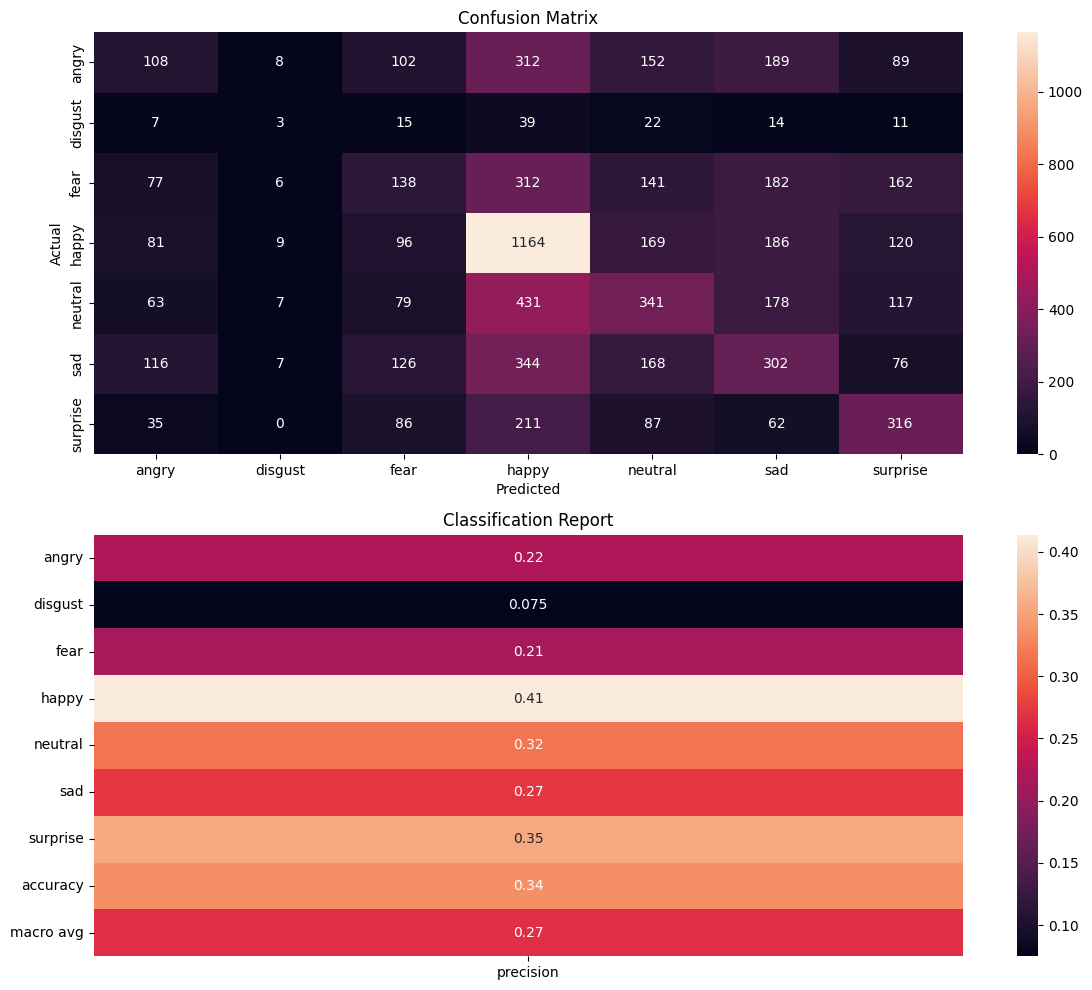

In [ ]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

enhancedensemblemodel.eval()
tk = tqdm(validloader, desc="EPOCH" + "[VALID]" + str(EPOCHS))

for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits_tuple = enhancedensemblemodel(images)
    print("Logits:", logits_tuple)  # Debugging line to understand the output structure

    # Check if the output is a tuple and handle accordingly
    if isinstance(logits_tuple, tuple):
        # Assuming you want to average the outputs
        logits = torch.mean(torch.stack(logits_tuple), dim=0)
    else:
        logits = logits_tuple

    # Now logits is a single Tensor, so you can apply argmax
    predicted_labels.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

# Compute the classification report
report = classification_report(true_labels, predicted_labels, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], output_dict=True)

# Convert report to DataFrame for easier plotting
report_df = pd.DataFrame(report).transpose()

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], columns=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

# Plotting
plt.figure(figsize=(12, 10))

# Plot confusion matrix
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Plot classification report
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
sns.heatmap(report_df.iloc[:-1, :-3], annot=True)
plt.title('Classification Report')

plt.tight_layout();
plt.show();

# F1-score

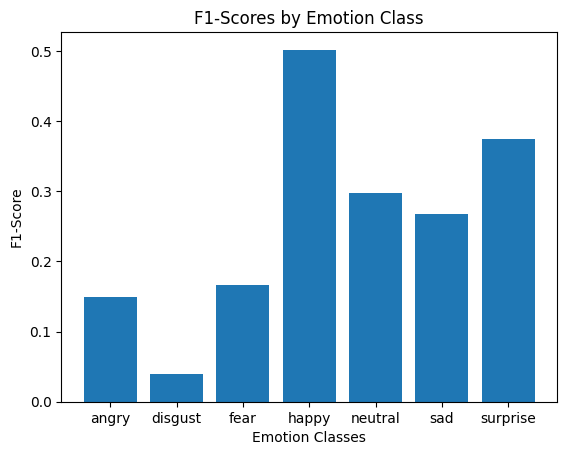

In [ ]:
import matplotlib.pyplot as plt

# Class names
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Assuming 'report' is a dictionary returned by classification_report with output_dict=True
f1_scores = [report[cls]['f1-score'] for cls in classes]

# Create a bar chart
plt.bar(classes, f1_scores)
plt.xlabel('Emotion Classes')
plt.ylabel('F1-Score')
plt.title('F1-Scores by Emotion Class')
plt.show()

# Calculate AUC and ROC

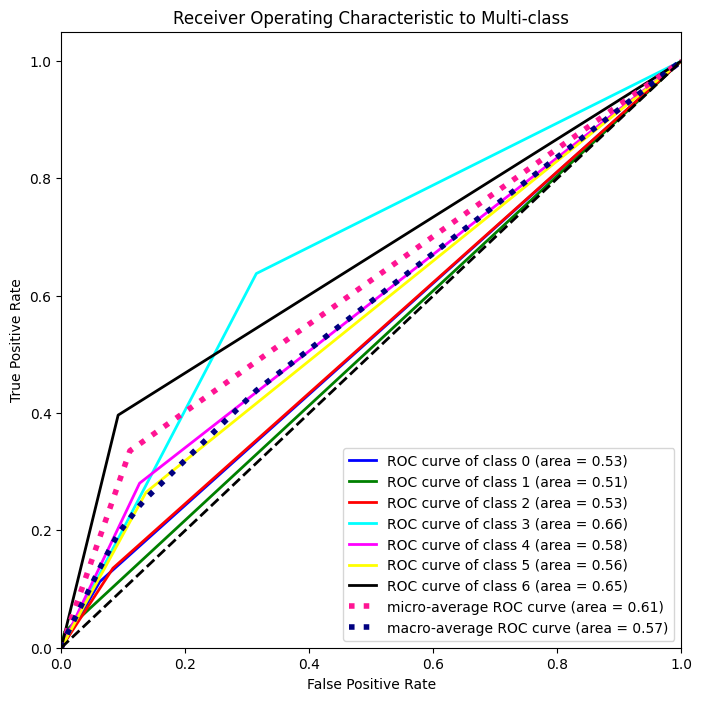

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle


# Binarize the output labels for multiclass
n_classes = 7  # Number of classes
y_test = label_binarize(true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
y_score = label_binarize(predicted_labels, classes=[0, 1, 2, 3, 4, 5, 6])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.show()


# Matthews Correlation Coefficient (MCC)

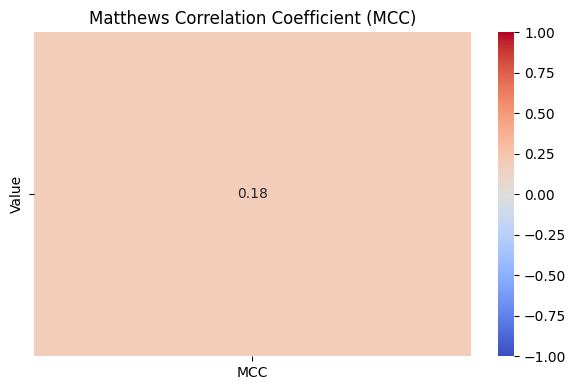

In [ ]:
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `true_labels` and `predicted_labels` are available from the previous classification task

# Calculate the Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(true_labels, predicted_labels)

# Create a more profound visualization
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap([[mcc]], annot=True, cmap='coolwarm', cbar=True, fmt=".2f", vmin=-1, vmax=1, ax=ax)

# Customize the plot to make it more beautiful
ax.set_xticklabels(['MCC'])
ax.set_yticklabels(['Value'])
plt.title('Matthews Correlation Coefficient (MCC)')
plt.tight_layout()

# Show the plot
plt.show()
